# This is true tracking

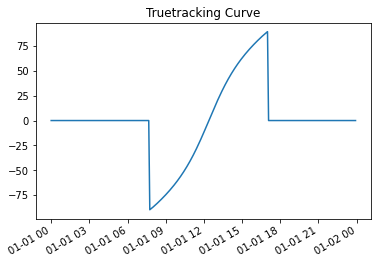

In [8]:
from pvlib import solarposition, tracking
import pandas as pd
import matplotlib.pyplot as pl


tz = 'US/Eastern'
lat, lon = 40, -80

times = pd.date_range('2019-01-01', '2019-01-02', closed = 'left', freq ='5 min', tz = tz)

solpos = solarposition.get_solarposition(times, lat, lon)

truetracking_angles = tracking.singleaxis(
    apparent_zenith = solpos['apparent_zenith'],
    apparent_azimuth = solpos['azimuth'],
    axis_tilt = 0,
    axis_azimuth = 180,
    max_angle = 90,
    backtrack = False, # for true tracking
    gcr = 0.5) # irrelevant for true tracking

truetracking_position = truetracking_angles['tracker_theta'].fillna(0)
truetracking_position.plot(title = 'Truetracking Curve')

plt.show()

# Back Tracking

Because truetracking yields steep tilt angle in morning and afternoon, it will cause row to row shading as the shadows from 
adjacent rows fall on each other. To prevent this, the trackers can rotate backwards when the sun is near the horizon--
"backtracking". The shading angle depends on row geometry, so the gcr parameter must be specified. The greater the gcr, the
tighter the row spacing and the more aggressively the array must backtrack.


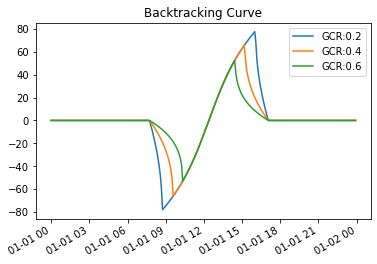

In [12]:
from pvlib import tracking
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for gcr in [0.2, 0.4, 0.6]:
    backtracking_angles = tracking.singleaxis(
        apparent_zenith = solpos['apparent_zenith'],
        apparent_azimuth = solpos['azimuth'],
        axis_tilt = 0,
        axis_azimuth = 180,
        max_angle = 90,
        backtrack = True,
        gcr = gcr)
    
    backtracking_position = backtracking_angles['tracker_theta'].fillna(0)
    backtracking_position.plot(title = 'Backtracking Curve',
                               label = 'GCR:{:0.01f}'.format(gcr),
                               ax = ax)
    
plt.legend()
plt.show()

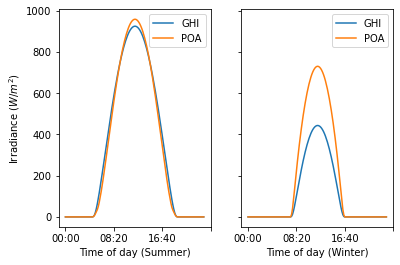

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pvlib import location 
from pvlib import irradiance
# for this example, we will use Golden, Colorado
tz = 'MST'
lat, lon = 39.755, -105.221

# creat location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)

# calculate clear-sky GHI and transposeto plane of array
# Define a function so that we can re-use the sequence of operation with different location
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq ='10min', periods = 6*24, tz=site_location.tz)
    #Generate clear sky data using the Ineichen model, which is the default
    #The get_clearsky method returns a dataframe with values for GHI, DNI, and DHI
    clearsky = site_location.get_clearsky(times)
    #Get solar azimuth and zenith to pass to the transposition function
    solar_position = site_location.get_solarposition(times=times)
    #Use the get_total_irradiance function to teanspose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt = tilt,
        surface_azimuth = surface_azimuth,
        dni = clearsky['dni'],
        ghi = clearsky['ghi'],
        dhi = clearsky['dhi'],
        solar_zenith = solar_position['apparent_zenith'],
        solar_azimuth = solar_position['azimuth'])
    # Return Dataframe with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

#Get irridiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-02-2020', 25, 180)
winter_irradiance = get_irradiance(site, '12-21-2020', 25, 180)

# Convert DataFrame Indexes to hour: Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1,ax2) = plt.subplots(1, 2, sharey= True)
summer_irradiance['GHI'].plot(ax=ax1, label = 'GHI')
summer_irradiance['POA'].plot(ax=ax1, label = 'POA')
winter_irradiance['GHI'].plot(ax=ax2, label = 'GHI')
winter_irradiance['POA'].plot(ax=ax2, label = 'POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax2.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()


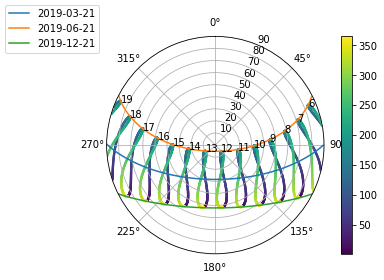

In [10]:
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tz = 'Asia/Calcutta'
lat, lon = 28.6, 77.2

times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', closed='left', freq = 'H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation']>0,:]

ax = plt.subplot(1,1,1, projection = 'polar')
# draw the analemma loops
points = ax.scatter(np.radians(solpos.azimuth), solpos.apparent_zenith, s=2, label=None, c=solpos.index.dayofyear)
ax.figure.colorbar(points)

#draw hour labels
for hour in np.unique(solpos.index.hour):
    # choose label position by the smallest radius for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    r = subset.apparent_zenith
    pos = solpos.loc[r.idxmin(),:]
    ax.text(np.radians(pos['azimuth']), pos['apparent_zenith'], str(hour))
    
#draw individual days
for date in pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation']>0,:]
    label = date.strftime('%Y-%m-%d')
    ax.plot(np.radians(solpos.azimuth), solpos.apparent_zenith, label=label)
    
ax.figure.legend(loc='upper left')

# change coordinates to be like a compass
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rmax(90)

plt.show()

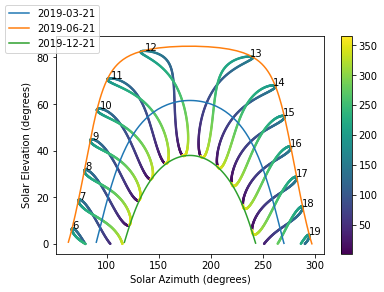

In [12]:
from pvlib import solarposition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tz = 'Asia/Calcutta'
lat, lon = 28.6, 77.2

times = pd.date_range('2019-01-01 00:00:00', '2020-01-01', closed='left', freq = 'H', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)
# remove nighttime
solpos = solpos.loc[solpos['apparent_elevation']>0,:]

fig, ax = plt.subplots()
points = ax.scatter(solpos.azimuth, solpos.apparent_elevation, s=2, c=solpos.index.dayofyear, label=None)
fig.colorbar(points)

for hour in np.unique(solpos.index.hour):
    # choose label position by the largest elevation for each hour
    subset = solpos.loc[solpos.index.hour == hour, :]
    height = subset.apparent_elevation
    pos = solpos.loc[height.idxmax(),:]
    ax.text(pos['azimuth'], pos['apparent_elevation'], str(hour))
    
for date in pd.to_datetime(['2019-03-21', '2019-06-21', '2019-12-21']):
    times = pd.date_range(date, date+pd.Timedelta('24h'), freq='5 min', tz=tz)
    solpos = solarposition.get_solarposition(times, lat, lon)
    solpos = solpos.loc[solpos['apparent_elevation']>0,:]
    label = date.strftime('%Y-%m-%d')
    ax.plot(solpos.azimuth, solpos.apparent_elevation, label=label)
    
ax.figure.legend(loc='upper left')
ax.set_xlabel('Solar Azimuth (degrees)')
ax.set_ylabel('Solar Elevation (degrees)')

plt.show()
    
    

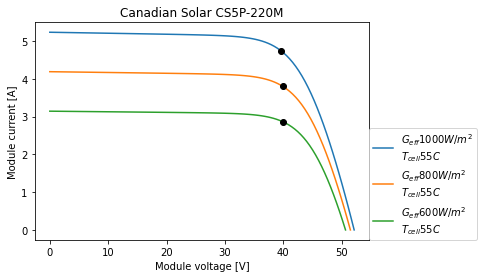

<Figure size 432x288 with 0 Axes>

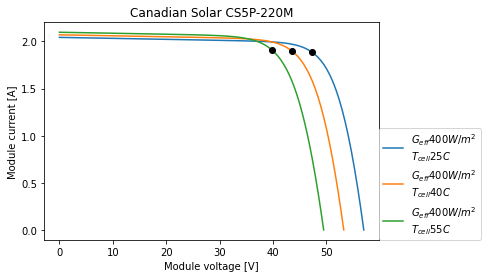

       i_sc       v_oc      i_mp       v_mp        p_mp
0  5.235561  52.129782  4.742078  39.617325  187.868460
1  4.190781  51.483032  3.805385  39.871330  151.725745
2  3.144837  50.649227  2.862258  39.952853  114.355370
       i_sc       v_oc      i_mp       v_mp       p_mp
0  2.043319  56.987478  1.886511  47.285357  89.204359
1  2.070523  53.238566  1.900933  43.492748  82.676788
2  2.097727  49.474043  1.911758  39.742278  75.977636


C:\Users\hp\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


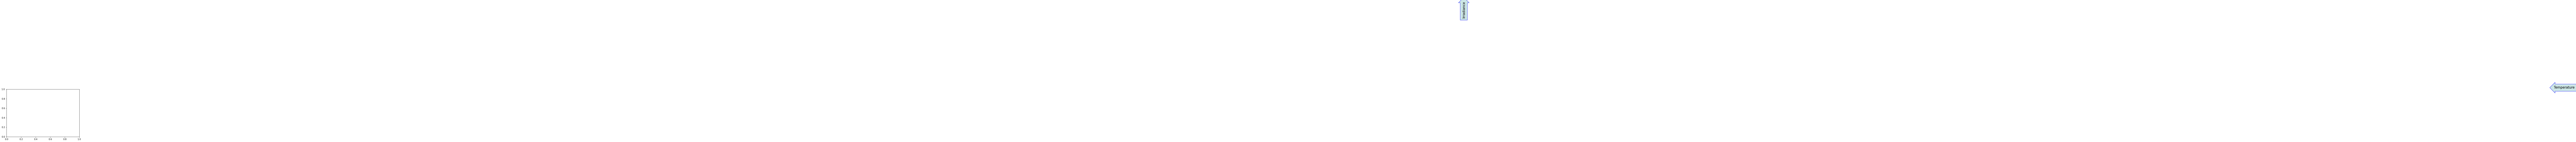

In [13]:
from pvlib import pvsystem
import pandas as pd
import matplotlib.pyplot as plt

# Example module parameters for the Canadian Solar CS5P-220M:
parameters = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'a_ref': 2.6373,
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
    
}

cases1 = [
    (1000, 55),
    (800, 55),
    (600, 55),
    #(400, 25),
    #(400, 40),
    #(400, 55)
]

cases2 = [
    (400, 25),
    (400, 40),
    (400, 55)
]

conditions1 = pd.DataFrame(cases1, columns=['Geff', 'Tcell'])
conditions2 = pd.DataFrame(cases2, columns=['Geff', 'Tcell'])

#adjust the reference parameters according to the operating
# conditions using the De Soto model:
IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
     conditions1['Geff'],
     conditions1['Tcell'],
     alpha_sc=parameters['alpha_sc'],
     a_ref=parameters['a_ref'],
     I_L_ref = parameters['I_L_ref'],
     I_o_ref = parameters['I_o_ref'],
     R_sh_ref = parameters['R_sh_ref'],
     R_s = parameters['R_s'],
     EgRef = 1.121,
     dEgdT =-0.0002677
)
I_L, I_0, R_s, R_sh, n_NsVth = pvsystem.calcparams_desoto(
     conditions2['Geff'],
     conditions2['Tcell'],
     alpha_sc=parameters['alpha_sc'],
     a_ref=parameters['a_ref'],
     I_L_ref = parameters['I_L_ref'],
     I_o_ref = parameters['I_o_ref'],
     R_sh_ref = parameters['R_sh_ref'],
     R_s = parameters['R_s'],
     EgRef = 1.121,
     dEgdT =-0.0002677
)
#plug the parameters into the SDE and solve for IV curves:
curve_info1 = pvsystem.singlediode(
    photocurrent = IL,
    saturation_current = I0,
    resistance_series = Rs,
    resistance_shunt = Rsh,
    nNsVth = nNsVth,
    ivcurve_pnts = 100,
    method = 'lambertw'
)

# plot the calculated curves:
plt.figure()
for i, case in conditions1.iterrows():
    label = (
        "$G_{eff}$"+f"{case['Geff']}$W/m^2$\n"
        "$T_{cell}$"+f"{case['Tcell']}$C$"
    )
    plt.plot(curve_info1['v'][i], curve_info1['i'][i], label=label)
    v_mp = curve_info1['v_mp'][i]
    i_mp = curve_info1['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')

plt.legend(loc=(1.0,0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(parameters['Name'])
plt.show()
plt.gcf().set_tight_layout(True)

#plug the parameters into the SDE and solve for IV curves:
curve_info2 = pvsystem.singlediode(
    photocurrent = I_L,
    saturation_current = I_0,
    resistance_series = R_s,
    resistance_shunt = R_sh,
    nNsVth = n_NsVth,
    ivcurve_pnts = 100,
    method = 'lambertw'
)

# plot the calculated curves:
plt.figure()
for i, case in conditions2.iterrows():
    label = (
        "$G_{eff}$"+f"{case['Geff']}$W/m^2$\n"
        "$T_{cell}$"+f"{case['Tcell']}$C$"
    )
    plt.plot(curve_info2['v'][i], curve_info2['i'][i], label=label)
    v_mp = curve_info2['v_mp'][i]
    i_mp = curve_info2['i_mp'][i]
    # mark the MPP
    plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')
        
plt.legend(loc=(1.0,0))
plt.xlabel('Module voltage [V]')
plt.ylabel('Module current [A]')
plt.title(parameters['Name'])
plt.show()
plt.gcf().set_tight_layout(True)


#draw trend arrows
def draw_arrow(ax, label, x0, y0, rotation, size, direction):
    style = direction + 'arrow'
    bbox_props = dict(boxstyle=style, fc=(0.8, 0.9, 0.9), ec="b", lw=1)
    t = ax.text(x0, y0, label, ha="left", va="bottom", rotation=rotation, 
                size=size, bbox=bbox_props, zorder = -1)
    
    bb = t.get_bbox_patch()
    bb.set_boxstyle(style, pad=0.6)
    
ax = plt.gca()
draw_arrow(ax, 'Irradiance', 20, 2.5, 90, 15, 'r')
draw_arrow(ax, 'Temperature', 35, 1, 0, 15, 'l')

print(pd.DataFrame({
    'i_sc': curve_info1['i_sc'],
    'v_oc': curve_info1['v_oc'],
    'i_mp': curve_info1['i_mp'],
    'v_mp': curve_info1['v_mp'],
    'p_mp': curve_info1['p_mp'],
}))
    
print(pd.DataFrame({
    'i_sc': curve_info2['i_sc'],
    'v_oc': curve_info2['v_oc'],
    'i_mp': curve_info2['i_mp'],
    'v_mp': curve_info2['v_mp'],
    'p_mp': curve_info2['p_mp'],
}))    

Vt is = 0.025745624999999994
eta_initial is = 1.4774919229399954
Rs_initial is = 0.1840324229353696 Ohms
Rsh_initial= 692.8597665964209 Ohms
[1.39580822e+00 2.17215097e-01 1.10489487e+03]
eta = 1.395808224754172
Rs = 0.2172150974973048
Rsh = 1104.8948729304138
Isat =  2.1922584839245491e-07 Amps
Iph = 8.841737886118326 Amps
Voc = 45.30000000001188
I = [8.839999758809821, 8.839838975834414, 8.83967819053459, 8.839517402745182, 8.839356612289288, 8.83919581897744, 8.839035022606705, 8.838874222959728, 8.838713419803712, 8.838552612889318, 8.838391801949491, 8.838230986698198, 8.83807016682908, 8.837909342014017, 8.837748511901564, 8.837587676115312, 8.8374268342521, 8.83726598588012, 8.837105130536887, 8.83694426772705, 8.83678339692006, 8.836622517547669, 8.836461629001251, 8.836300730628935, 8.83613982173253, 8.835978901564236, 8.835817969323111, 8.835657024151311, 8.835496065130028, 8.835335091275171, 8.835174101532722, 8.835013094773773, 8.834852069789193, 8.834691025283938, 8.834529

<function matplotlib.pyplot.show(*args, **kw)>

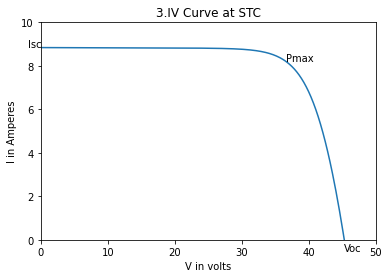

In [16]:
import numpy as np
import math
from scipy.optimize import fsolve
import pvlib
import matplotlib.pyplot as plt

Vmp = 36.6
Imp = 8.20
Voc = 45.3
Isc = 8.84
Ncell = 72

k = 1.38*(10**-23)
q = 1.6*(10**-19)
T = 298.5 # Temperature in Kelvin
Vt = (k*T)/q
print("Vt is =",Vt)

def eta_initial():
    n1 = 2*Vmp - Voc
    n2 = Ncell * Vt
    n3 = np.log((Isc - Imp)/ Isc)
    n4 = Imp / (Isc - Imp)
    n5 = n1/(n2*(n3+n4))
    # print ("inieta = ", n5)
    return n5
eta_ini = eta_initial()
print("eta_initial is =",eta_ini)

def Rs_initial():
    n1 = Vmp/Imp
    n2 = (2*Vmp-Voc)/(Isc-Imp)
    n3 = (np.log((Isc-Imp)/Isc)+(Imp/(Isc-Imp)))
    n4 = n2/n3
    n5 = n1-n4
    return n5
Rs_ini = Rs_initial()
print("Rs_initial is =",Rs_ini,"Ohms")

def Rsh_initial():
    n1 = Isc/(eta_ini*Ncell*Vt)
    n2 = (Rs_ini*Isc-Voc)/(eta_ini*Ncell*Vt)
    n3 = np.exp(n2)
    n4 = n1*n3
    n5 = Rs_ini/n4
    n6 = np.sqrt(n5)
    return n6

Rsh_ini=Rsh_initial()
print("Rsh_initial=",Rsh_ini,"Ohms")


def parameter_function(x):
    eta = x[0]
    Rs = x[1]
    Rsh = x[2]
    F = np.zeros(np.size(x))
    F[0] = Imp-Isc+(Vmp+Imp*Rs-Isc*Rs)/Rsh+(Isc-(Voc-Isc*Rs)/Rsh)*(np.exp((-Voc+Vmp+Imp*Rs)/(eta*Ncell*Vt)))
    F[1] = Imp+Vmp*(((-(-Voc+Isc*Rsh+Isc*Rs)/(eta*Ncell*Vt*Rsh))*(np.exp((-Voc+Vmp+Imp*Rs)/(eta*Ncell*Vt)))-1/Rsh)/(1+((-Voc+Isc*Rsh+Isc*Rs)/(eta*Ncell*Vt*Rsh) *Rs*np.exp((-Voc+Vmp+Imp*Rs)/(eta*Ncell*Vt)))+Rs/Rsh))
    F[2] = 1/Rsh+(((-(-Voc+Isc*Rsh+Isc*Rs)/(eta*Ncell*Vt*Rsh))*(np.exp((-Voc+Isc*Rs)/(eta*Ncell*Vt)))-1/Rsh)/(1+(((-Voc+Isc*Rsh+Isc*Rs)/(eta*Ncell*Vt*Rsh))*Rs*(np.exp((-Voc+Isc*Rs)/(eta*Ncell*Vt))))+Rs/Rsh))
    return F

x_ini = np.array([eta_ini, Rs_ini, Rsh_ini])
x = fsolve(parameter_function,x_ini)
print(x)

eta = x[0]
Rs = x[1]
Rsh = x[2]
print("eta =",eta)
print("Rs =",Rs)
print("Rsh =",Rsh)

def I_saturation():
    n1=(Voc-Isc*Rs)/Rsh
    n2=Isc-n1
    #print(n2)
    n3=np.exp(-Voc/(eta*Ncell*Vt))
    #print(n3)
    n4=n2*n3
    return n4

I_saturation()
Isat = I_saturation()
print("Isat = ", Isat, "Amps")

def I_photon():
    n1=np.exp(Voc/(eta*Ncell*Vt))
    #print(n1)
    n2=Isat*n1
    #print(n2)
    n3=Voc/Rsh
    #print(n3)
    n4=n2+n3
    return n4

I_photon()
Iph=I_photon()
print("Iph =", Iph, "Amps")

def V_oc(x):
    Voc=x[0]
    F=np.zeros(np.size(x))
    F[0]= Iph-Isat*(np.exp(Voc/(eta*Ncell*Vt)))-Voc/Rsh
    return F

x=fsolve(V_oc,72*0.6)
Voc=x[0]
print("Voc =", Voc)

i = []
def I_sc(x):
    I=x[0]
    F=np.zeros(np.size(x))
    F[0]= -I + Iph - Isat*(np.exp((V+I*Rs)/(eta*Ncell*Vt))-1)-(V+I*Rs)/Rsh
    return F

Vx = np.linspace(0, Voc, num=256)
for V in Vx:
    x = fsolve(I_sc, Iph)
    i.extend(x)
    
print("I =", i)
print("V =", Vx)

plt.plot(Vx, i)
plt.title('3.IV Curve at STC')
plt.xlabel('V in volts')
plt.ylabel('I in Amperes')
plt.axis([0, 50, 0, 10])
plt.annotate('Voc', xy=(45.3, 0), xytext=(45.3,-0.5))
plt.annotate('Isc', xy=(0, 8.839999758809821), xytext=(-2,8.839999758809821))
plt.annotate('Pmax', xy=(36.6040393, 8.201053667922631))
plt.show




p = [0.00000000e+00 1.57037139e+00 3.14068566e+00 4.71094280e+00
 6.28114282e+00 7.85128570e+00 9.42137145e+00 1.09914001e+01
 1.25613715e+01 1.41312859e+01 1.57011431e+01 1.72709431e+01
 1.88406860e+01 2.04103718e+01 2.19800004e+01 2.35495719e+01
 2.51190862e+01 2.66885433e+01 2.82579432e+01 2.98272860e+01
 3.13965716e+01 3.29658000e+01 3.45349712e+01 3.61040852e+01
 3.76731420e+01 3.92421416e+01 4.08110839e+01 4.23799690e+01
 4.39487969e+01 4.55175675e+01 4.70862808e+01 4.86549368e+01
 5.02235355e+01 5.17920769e+01 5.33605610e+01 5.49289876e+01
 5.64973569e+01 5.80656688e+01 5.96339232e+01 6.12021202e+01
 6.27702597e+01 6.43383417e+01 6.59063660e+01 6.74743328e+01
 6.90422420e+01 7.06100934e+01 7.21778871e+01 7.37456230e+01
 7.53133011e+01 7.68809212e+01 7.84484834e+01 8.00159875e+01
 8.15834334e+01 8.31508212e+01 8.47181506e+01 8.62854216e+01
 8.78526341e+01 8.94197879e+01 9.09868829e+01 9.25539191e+01
 9.41208961e+01 9.56878140e+01 9.72546724e+01 9.88214713e+01
 1.00388210e+02 1.01

<function matplotlib.pyplot.show(*args, **kw)>

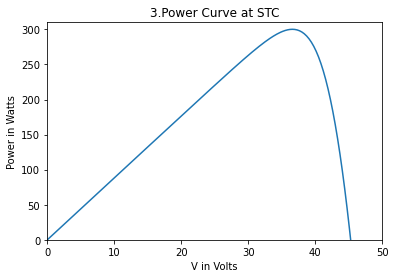

In [17]:
p=[]
p=np.multiply(Vx, i)
print("p =", p)
plt.plot(Vx, p)
plt.axis([0, 50, 0, 310])
plt.title('3.Power Curve at STC')
plt.xlabel('V in Volts')
plt.ylabel('Power in Watts')
plt.show


In [49]:
import numpy as np
import math
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Rs_STC =  0.2172150974973048
Rsh_STC = 1104.8948729304138
Iph_STC = 8.841737886118326
Isat_STC = 2.1922584839245491e-07
eta = 1.395808224754172
Vt_STC = 0.025745624999999994
Ncell = 72
Voc_STC = 45.30000000001188
Isc_STC = 8.839999758809823
Pmax_STC = 300.1199710523156
FF_STC = 0.7494530661370086
alpha = 0.0006

Kb = 1.38*(10**(-23))
q = 1.6*(10**(-19))

G_STC = 1000
T_STC =298
G = 1000
Temp = np.arange(253,363,10)
Ksc = np.log((6.56-alpha*(293-298)))/(np.log(800/100))
Eg = 0.6
print("Ksc =", Ksc)

Voc_T=[]
Isc_T=[]
Iph_T=[]
Isat_T=[]
Vt_T=[]

for T in Temp:
    Vt = (Kb * T)/q
    Isc_GT = ((G/G_STC)**Ksc) * (Isc_STC+alpha*(T-T_STC))
    Rs_GT = Rs_STC
    Rsh_GT = (G_STC/G)*Rsh_STC
    Iph_GT = Isc_GT*(1+(Rs_GT/(Rsh_GT)))
    Isat_GT = Isat_STC*((T/T_STC))**3 * np.exp(((q*Eg)/(eta*Kb))*((1/T_STC)-(1/T)))
    def V_oc(x):
        Voc=x[0]
        F=np.zeros(np.size(x))
        F[0]= Iph_GT-Isat_GT*(np.exp(Voc/(eta*Ncell*Vt)))-Voc/Rsh_GT
        return F
    
    
    x=fsolve(V_oc, 72.06)
    Voc_T.extend(x)
    Isc_T.append(Isc_GT)
    Iph_T.append(Iph_GT)
    Isat_T.append(Isat_GT)
    Vt_T.append(Vt)
    
print("Voc_T =", Voc_T)
print("Isc_T =", Isc_T)
print("Vt_T =", Vt_T)

Ksc = 0.9047851443670281
Voc_T = [45.98857607996657, 45.83527958496705, 45.672215796960806, 45.499747184395396, 45.31821057929331, 45.12791980406801, 44.92916795129319, 44.72222937181836, 44.507361416514875, 44.28480596864054, 44.054790797369535]
Isc_T = [8.812999758809823, 8.818999758809822, 8.824999758809822, 8.830999758809822, 8.836999758809823, 8.842999758809823, 8.848999758809823, 8.854999758809823, 8.860999758809823, 8.866999758809822, 8.872999758809822]
Vt_T = [0.021821249999999993, 0.022683749999999996, 0.023546249999999994, 0.024408749999999996, 0.025271249999999995, 0.02613374999999999, 0.026996249999999996, 0.02785874999999999, 0.02872124999999999, 0.029583749999999992, 0.03044624999999999]


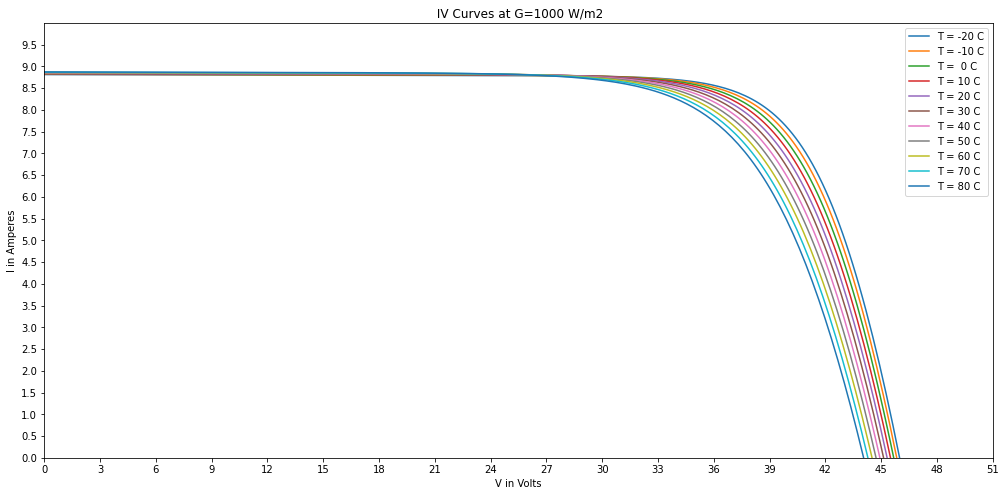

In [99]:
k0=[]
k1=[]
k2=[]
k3=[]
k4=[]
k5=[]
k6=[]
k7=[]
k8=[]
k9=[]
k10=[]
a0=[]
a1=[]
a2=[]
a3=[]
a4=[]
a5=[]
a6=[]
a7=[]
a8=[]
a9=[]
a10=[]
i=[k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10]#current arrays
v=[a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10]#voltage arrays
j=0
for j in range(11):
    def I_sc(x):
        I=x[0]
        F=np.zeros(np.size(x))
        F[0]=-I+Iph_T[j]-Isat_T[j]*(np.exp((V+I*Rs_GT)/(eta*Ncell*Vt_T[j]))-1)-(V+I*Rs_GT)/Rsh_GT
        return F
    
    Vx = np.linspace(0,Voc_T[j], num=256)
    for V in Vx:
        x = fsolve(I_sc,Iph_T[j])
        i[j].extend(x)
    v[j].extend(Vx)
    
f = plt.figure()
f.set_figwidth(17)
f.set_figheight(8)      
plt.plot(a0,k0,label='T = -20 C')    
plt.plot(a1,k1,label='T = -10 C')    
plt.plot(a2,k2,label='T =  0 C')    
plt.plot(a3,k3,label='T = 10 C')    
plt.plot(a4,k4,label='T = 20 C')    
plt.plot(a5,k5,label='T = 30 C')    
plt.plot(a6,k6,label='T = 40 C')    
plt.plot(a7,k7,label='T = 50 C') 
plt.plot(a8,k8,label='T = 60 C')    
plt.plot(a9,k9,label='T = 70 C') 
plt.plot(a10,k10,label='T = 80 C')  
plt.axis([0, 50, 0, 10])
plt.legend()
plt.margins(2,2)
plt.xticks(np.arange(0,53,3))
plt.yticks(np.arange(0,10,0.5))
plt.title(' IV Curves at G=1000 W/m2')
plt.xlabel('V in Volts')
plt.ylabel('I in Amperes')
plt.show()

In [57]:
p=[]
b=0
Pmax_T=[]
for b in range(11):
    p=np.multiply(v[b],i[b])
    Pmax_T.append(np.amax(p))
print("Pmax_T =", Pmax_T)    

Pmax_T = [313.82749919215274, 310.73782246952754, 307.6027538000508, 304.4246060031112, 301.2055549619582, 297.95313679534263, 294.66735905316966, 291.34652228456076, 287.99235509085776, 284.60652792000997, 281.19065933152217]


In [58]:
FF_T=[]
for b in range(11):
    FF_T.append(Pmax_T[b]/(Voc_T[b]*Isc_T[b]))

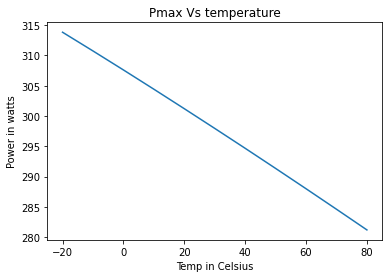

In [59]:
TempC=np.arange(-20,90,10)
plt.plot(TempC, Pmax_T)
plt.title('Pmax Vs temperature')
plt.xlabel('Temp in Celsius')
plt.ylabel('Power in watts')
plt.show()

In [67]:
p=[]
j=[]
b=0
for b in range(11):
    j=np.multiply(v[b],i[b])
    p.append(j)
print(p)

[array([0.00000000e+00, 1.58937178e+00, 3.17868470e+00, 4.76793875e+00,
       6.35713394e+00, 7.94627027e+00, 9.53534773e+00, 1.11243663e+01,
       1.27133261e+01, 1.43022269e+01, 1.58910689e+01, 1.74798521e+01,
       1.90685764e+01, 2.06572418e+01, 2.22458483e+01, 2.38343960e+01,
       2.54228848e+01, 2.70113148e+01, 2.85996858e+01, 3.01879981e+01,
       3.17762514e+01, 3.33644459e+01, 3.49525815e+01, 3.65406582e+01,
       3.81286761e+01, 3.97166351e+01, 4.13045352e+01, 4.28923765e+01,
       4.44801589e+01, 4.60678824e+01, 4.76555470e+01, 4.92431528e+01,
       5.08306997e+01, 5.24181877e+01, 5.40056168e+01, 5.55929871e+01,
       5.71802984e+01, 5.87675509e+01, 6.03547445e+01, 6.19418792e+01,
       6.35289550e+01, 6.51159719e+01, 6.67029299e+01, 6.82898290e+01,
       6.98766692e+01, 7.14634505e+01, 7.30501728e+01, 7.46368362e+01,
       7.62234407e+01, 7.78099863e+01, 7.93964729e+01, 8.09829006e+01,
       8.25692693e+01, 8.41555790e+01, 8.57418297e+01, 8.73280215e+01,
     

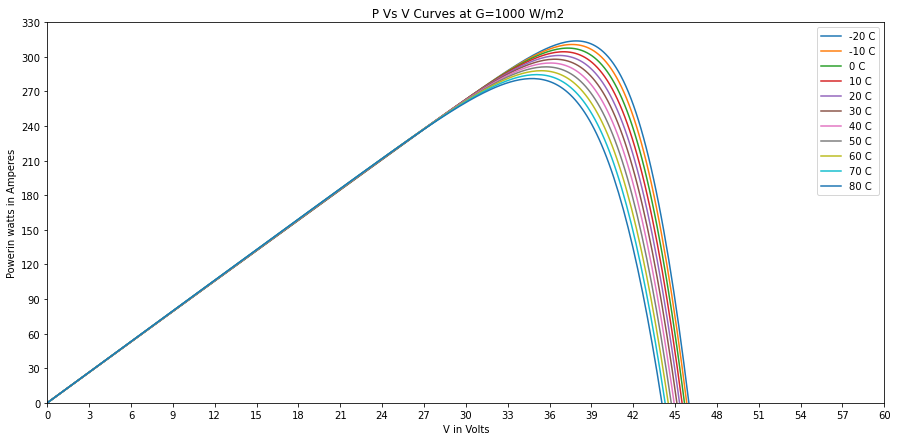

In [97]:
a0= [0.00000000e+00, 1.58937178e+00, 3.17868470e+00, 4.76793875e+00,
       6.35713394e+00, 7.94627027e+00, 9.53534773e+00, 1.11243663e+01,
       1.27133261e+01, 1.43022269e+01, 1.58910689e+01, 1.74798521e+01,
       1.90685764e+01, 2.06572418e+01, 2.22458483e+01, 2.38343960e+01,
       2.54228848e+01, 2.70113148e+01, 2.85996858e+01, 3.01879981e+01,
       3.17762514e+01, 3.33644459e+01, 3.49525815e+01, 3.65406582e+01,
       3.81286761e+01, 3.97166351e+01, 4.13045352e+01, 4.28923765e+01,
       4.44801589e+01, 4.60678824e+01, 4.76555470e+01, 4.92431528e+01,
       5.08306997e+01, 5.24181877e+01, 5.40056168e+01, 5.55929871e+01,
       5.71802984e+01, 5.87675509e+01, 6.03547445e+01, 6.19418792e+01,
       6.35289550e+01, 6.51159719e+01, 6.67029299e+01, 6.82898290e+01,
       6.98766692e+01, 7.14634505e+01, 7.30501728e+01, 7.46368362e+01,
       7.62234407e+01, 7.78099863e+01, 7.93964729e+01, 8.09829006e+01,
       8.25692693e+01, 8.41555790e+01, 8.57418297e+01, 8.73280215e+01,
       8.89141542e+01, 9.05002279e+01, 9.20862426e+01, 9.36721982e+01,
       9.52580948e+01, 9.68439322e+01, 9.84297105e+01, 1.00015430e+02,
       1.01601090e+02, 1.03186690e+02, 1.04772232e+02, 1.06357714e+02,
       1.07943137e+02, 1.09528501e+02, 1.11113805e+02, 1.12699050e+02,
       1.14284235e+02, 1.15869361e+02, 1.17454427e+02, 1.19039433e+02,
       1.20624380e+02, 1.22209266e+02, 1.23794093e+02, 1.25378859e+02,
       1.26963565e+02, 1.28548211e+02, 1.30132796e+02, 1.31717321e+02,
       1.33301785e+02, 1.34886188e+02, 1.36470529e+02, 1.38054810e+02,
       1.39639028e+02, 1.41223184e+02, 1.42807279e+02, 1.44391310e+02,
       1.45975279e+02, 1.47559184e+02, 1.49143025e+02, 1.50726803e+02,
       1.52310515e+02, 1.53894162e+02, 1.55477743e+02, 1.57061258e+02,
       1.58644705e+02, 1.60228085e+02, 1.61811395e+02, 1.63394635e+02,
       1.64977804e+02, 1.66560901e+02, 1.68143925e+02, 1.69726874e+02,
       1.71309747e+02, 1.72892542e+02, 1.74475257e+02, 1.76057890e+02,
       1.77640440e+02, 1.79222904e+02, 1.80805279e+02, 1.82387562e+02,
       1.83969752e+02, 1.85551843e+02, 1.87133833e+02, 1.88715717e+02,
       1.90297492e+02, 1.91879152e+02, 1.93460693e+02, 1.95042108e+02,
       1.96623392e+02, 1.98204537e+02, 1.99785537e+02, 2.01366382e+02,
       2.02947066e+02, 2.04527577e+02, 2.06107905e+02, 2.07688039e+02,
       2.09267966e+02, 2.10847673e+02, 2.12427145e+02, 2.14006364e+02,
       2.15585314e+02, 2.17163975e+02, 2.18742325e+02, 2.20320342e+02,
       2.21897999e+02, 2.23475270e+02, 2.25052124e+02, 2.26628528e+02,
       2.28204446e+02, 2.29779838e+02, 2.31354662e+02, 2.32928871e+02,
       2.34502413e+02, 2.36075233e+02, 2.37647270e+02, 2.39218457e+02,
       2.40788722e+02, 2.42357985e+02, 2.43926160e+02, 2.45493153e+02,
       2.47058861e+02, 2.48623171e+02, 2.50185960e+02, 2.51747097e+02,
       2.53306433e+02, 2.54863811e+02, 2.56419058e+02, 2.57971983e+02,
       2.59522381e+02, 2.61070027e+02, 2.62614675e+02, 2.64156059e+02,
       2.65693887e+02, 2.67227840e+02, 2.68757573e+02, 2.70282709e+02,
       2.71802835e+02, 2.73317505e+02, 2.74826229e+02, 2.76328476e+02,
       2.77823667e+02, 2.79311170e+02, 2.80790300e+02, 2.82260309e+02,
       2.83720383e+02, 2.85169637e+02, 2.86607108e+02, 2.88031749e+02,
       2.89442420e+02, 2.90837884e+02, 2.92216795e+02, 2.93577692e+02,
       2.94918987e+02, 2.96238959e+02, 2.97535736e+02, 2.98807293e+02,
       3.00051430e+02, 3.01265765e+02, 3.02447720e+02, 3.03594502e+02,
       3.04703091e+02, 3.05770225e+02, 3.06792378e+02, 3.07765746e+02,
       3.08686227e+02, 3.09549402e+02, 3.10350516e+02, 3.11084458e+02,
       3.11745737e+02, 3.12328468e+02, 3.12826345e+02, 3.13232626e+02,
       3.13540112e+02, 3.13741126e+02, 3.13827499e+02, 3.13790556e+02,
       3.13621099e+02, 3.13309399e+02, 3.12845188e+02, 3.12217656e+02,
       3.11415451e+02, 3.10426686e+02, 3.09238948e+02, 3.07839317e+02,
       3.06214386e+02, 3.04350295e+02, 3.02232762e+02, 2.99847131e+02,
       2.97178420e+02, 2.94211379e+02, 2.90930556e+02, 2.87320362e+02,
       2.83365150e+02, 2.79049294e+02, 2.74357268e+02, 2.69273737e+02,
       2.63783638e+02, 2.57872266e+02, 2.51525355e+02, 2.44729163e+02,
       2.37470539e+02, 2.29736997e+02, 2.21516774e+02, 2.12798884e+02,
       2.03573162e+02, 1.93830297e+02, 1.83561861e+02, 1.72760318e+02,
       1.61419035e+02, 1.49532277e+02, 1.37095194e+02, 1.24103804e+02,
       1.10554965e+02, 9.64463410e+01, 8.17763691e+01, 6.65442136e+01,
       5.07497232e+01, 3.43933840e+01, 1.74762713e+01, 1.68401170e-07] 
a1 = [0.00000000e+00, 1.58515241e+00, 3.17024634e+00, 4.75528180e+00,
       6.34025879e+00, 7.92517730e+00, 9.51003734e+00, 1.10948389e+01,
       1.26795820e+01, 1.42642666e+01, 1.58488928e+01, 1.74334604e+01,
       1.90179696e+01, 2.06024204e+01, 2.21868126e+01, 2.37711464e+01,
       2.53554217e+01, 2.69396385e+01, 2.85237968e+01, 3.01078967e+01,
       3.16919380e+01, 3.32759209e+01, 3.48598454e+01, 3.64437113e+01,
       3.80275187e+01, 3.96112677e+01, 4.11949582e+01, 4.27785902e+01,
       4.43621637e+01, 4.59456787e+01, 4.75291352e+01, 4.91125332e+01,
       5.06958727e+01, 5.22791537e+01, 5.38623762e+01, 5.54455403e+01,
       5.70286457e+01, 5.86116927e+01, 6.01946812e+01, 6.17776111e+01,
       6.33604825e+01, 6.49432954e+01, 6.65260497e+01, 6.81087455e+01,
       6.96913827e+01, 7.12739614e+01, 7.28564814e+01, 7.44389429e+01,
       7.60213458e+01, 7.76036901e+01, 7.91859758e+01, 8.07682028e+01,
       8.23503712e+01, 8.39324809e+01, 8.55145320e+01, 8.70965243e+01,
       8.86784579e+01, 9.02603327e+01, 9.18421488e+01, 9.34239060e+01,
       9.50056044e+01, 9.65872439e+01, 9.81688246e+01, 9.97503462e+01,
       1.01331809e+02, 1.02913212e+02, 1.04494557e+02, 1.06075842e+02,
       1.07657068e+02, 1.09238235e+02, 1.10819342e+02, 1.12400390e+02,
       1.13981379e+02, 1.15562307e+02, 1.17143176e+02, 1.18723985e+02,
       1.20304734e+02, 1.21885423e+02, 1.23466051e+02, 1.25046619e+02,
       1.26627126e+02, 1.28207573e+02, 1.29787958e+02, 1.31368282e+02,
       1.32948544e+02, 1.34528744e+02, 1.36108882e+02, 1.37688957e+02,
       1.39268970e+02, 1.40848919e+02, 1.42428804e+02, 1.44008625e+02,
       1.45588381e+02, 1.47168071e+02, 1.48747696e+02, 1.50327253e+02,
       1.51906743e+02, 1.53486165e+02, 1.55065518e+02, 1.56644800e+02,
       1.58224011e+02, 1.59803149e+02, 1.61382214e+02, 1.62961203e+02,
       1.64540116e+02, 1.66118951e+02, 1.67697705e+02, 1.69276378e+02,
       1.70854966e+02, 1.72433468e+02, 1.74011881e+02, 1.75590202e+02,
       1.77168428e+02, 1.78746556e+02, 1.80324583e+02, 1.81902505e+02,
       1.83480316e+02, 1.85058014e+02, 1.86635592e+02, 1.88213045e+02,
       1.89790368e+02, 1.91367554e+02, 1.92944596e+02, 1.94521486e+02,
       1.96098216e+02, 1.97674776e+02, 1.99251158e+02, 2.00827350e+02,
       2.02403340e+02, 2.03979116e+02, 2.05554664e+02, 2.07129969e+02,
       2.08705014e+02, 2.10279781e+02, 2.11854252e+02, 2.13428404e+02,
       2.15002215e+02, 2.16575660e+02, 2.18148711e+02, 2.19721339e+02,
       2.21293511e+02, 2.22865192e+02, 2.24436344e+02, 2.26006925e+02,
       2.27576891e+02, 2.29146191e+02, 2.30714772e+02, 2.32282576e+02,
       2.33849539e+02, 2.35415593e+02, 2.36980663e+02, 2.38544667e+02,
       2.40107515e+02, 2.41669113e+02, 2.43229354e+02, 2.44788126e+02,
       2.46345303e+02, 2.47900751e+02, 2.49454324e+02, 2.51005863e+02,
       2.52555193e+02, 2.54102128e+02, 2.55646461e+02, 2.57187972e+02,
       2.58726419e+02, 2.60261538e+02, 2.61793046e+02, 2.63320632e+02,
       2.64843959e+02, 2.66362663e+02, 2.67876347e+02, 2.69384578e+02,
       2.70886890e+02, 2.72382775e+02, 2.73871680e+02, 2.75353008e+02,
       2.76826109e+02, 2.78290279e+02, 2.79744753e+02, 2.81188702e+02,
       2.82621229e+02, 2.84041358e+02, 2.85448034e+02, 2.86840114e+02,
       2.88216358e+02, 2.89575425e+02, 2.90915862e+02, 2.92236099e+02,
       2.93534435e+02, 2.94809033e+02, 2.96057906e+02, 2.97278909e+02,
       2.98469725e+02, 2.99627853e+02, 3.00750597e+02, 3.01835050e+02,
       3.02878083e+02, 3.03876325e+02, 3.04826152e+02, 3.05723670e+02,
       3.06564696e+02, 3.07344746e+02, 3.08059013e+02, 3.08702352e+02,
       3.09269263e+02, 3.09753871e+02, 3.10149913e+02, 3.10450719e+02,
       3.10649199e+02, 3.10737822e+02, 3.10708614e+02, 3.10553137e+02,
       3.10262483e+02, 3.09827272e+02, 3.09237640e+02, 3.08483248e+02,
       3.07553277e+02, 3.06436445e+02, 3.05121010e+02, 3.03594795e+02,
       3.01845208e+02, 2.99859270e+02, 2.97623648e+02, 2.95124696e+02,
       2.92348503e+02, 2.89280936e+02, 2.85907704e+02, 2.82214412e+02,
       2.78186631e+02, 2.73809960e+02, 2.69070101e+02, 2.63952929e+02,
       2.58444561e+02, 2.52531434e+02, 2.46200368e+02, 2.39438638e+02,
       2.32234031e+02, 2.24574913e+02, 2.16450271e+02, 2.07849765e+02,
       1.98763768e+02, 1.89183390e+02, 1.79100508e+02, 1.68507779e+02,
       1.57398649e+02, 1.45767351e+02, 1.33608901e+02, 1.20919085e+02,
       1.07694437e+02, 9.39322184e+01, 7.96303860e+01, 6.47875623e+01,
       4.94029983e+01, 3.34765359e+01, 1.70085684e+01, 4.06134059e-07]
a2 =   [0.00000000e+00, 1.58058780e+00, 3.16111754e+00, 4.74158922e+00,
       6.32200285e+00, 7.90235841e+00, 9.48265591e+00, 1.10628954e+01,
       1.26430767e+01, 1.42232001e+01, 1.58032653e+01, 1.73832725e+01,
       1.89632216e+01, 2.05431127e+01, 2.21229457e+01, 2.37027207e+01,
       2.52824375e+01, 2.68620963e+01, 2.84416971e+01, 3.00212397e+01,
       3.16007243e+01, 3.31801508e+01, 3.47595193e+01, 3.63388296e+01,
       3.79180819e+01, 3.94972761e+01, 4.10764123e+01, 4.26554903e+01,
       4.42345102e+01, 4.58134721e+01, 4.73923758e+01, 4.89712215e+01,
       5.05500090e+01, 5.21287384e+01, 5.37074097e+01, 5.52860229e+01,
       5.68645780e+01, 5.84430749e+01, 6.00215137e+01, 6.15998943e+01,
       6.31782168e+01, 6.47564811e+01, 6.63346872e+01, 6.79128351e+01,
       6.94909248e+01, 7.10689563e+01, 7.26469296e+01, 7.42248446e+01,
       7.58027013e+01, 7.73804997e+01, 7.89582398e+01, 8.05359216e+01,
       8.21135450e+01, 8.36911101e+01, 8.52686167e+01, 8.68460648e+01,
       8.84234545e+01, 9.00007856e+01, 9.15780581e+01, 9.31552720e+01,
       9.47324272e+01, 9.63095237e+01, 9.78865614e+01, 9.94635402e+01,
       1.01040460e+02, 1.02617321e+02, 1.04194123e+02, 1.05770865e+02,
       1.07347548e+02, 1.08924172e+02, 1.10500737e+02, 1.12077241e+02,
       1.13653686e+02, 1.15230071e+02, 1.16806395e+02, 1.18382660e+02,
       1.19958864e+02, 1.21535007e+02, 1.23111089e+02, 1.24687109e+02,
       1.26263068e+02, 1.27838966e+02, 1.29414801e+02, 1.30990573e+02,
       1.32566283e+02, 1.34141929e+02, 1.35717511e+02, 1.37293029e+02,
       1.38868482e+02, 1.40443870e+02, 1.42019191e+02, 1.43594445e+02,
       1.45169632e+02, 1.46744749e+02, 1.48319798e+02, 1.49894776e+02,
       1.51469682e+02, 1.53044516e+02, 1.54619275e+02, 1.56193960e+02,
       1.57768567e+02, 1.59343095e+02, 1.60917544e+02, 1.62491909e+02,
       1.64066191e+02, 1.65640385e+02, 1.67214491e+02, 1.68788504e+02,
       1.70362423e+02, 1.71936243e+02, 1.73509962e+02, 1.75083575e+02,
       1.76657080e+02, 1.78230470e+02, 1.79803741e+02, 1.81376889e+02,
       1.82949907e+02, 1.84522790e+02, 1.86095530e+02, 1.87668120e+02,
       1.89240552e+02, 1.90812819e+02, 1.92384910e+02, 1.93956815e+02,
       1.95528524e+02, 1.97100025e+02, 1.98671304e+02, 2.00242348e+02,
       2.01813142e+02, 2.03383669e+02, 2.04953911e+02, 2.06523848e+02,
       2.08093461e+02, 2.09662726e+02, 2.11231618e+02, 2.12800110e+02,
       2.14368174e+02, 2.15935777e+02, 2.17502886e+02, 2.19069463e+02,
       2.20635468e+02, 2.22200858e+02, 2.23765584e+02, 2.25329596e+02,
       2.26892837e+02, 2.28455248e+02, 2.30016762e+02, 2.31577309e+02,
       2.33136812e+02, 2.34695187e+02, 2.36252344e+02, 2.37808184e+02,
       2.39362602e+02, 2.40915481e+02, 2.42466697e+02, 2.44016115e+02,
       2.45563588e+02, 2.47108956e+02, 2.48652048e+02, 2.50192677e+02,
       2.51730640e+02, 2.53265719e+02, 2.54797676e+02, 2.56326254e+02,
       2.57851175e+02, 2.59372137e+02, 2.60888814e+02, 2.62400852e+02,
       2.63907869e+02, 2.65409451e+02, 2.66905149e+02, 2.68394478e+02,
       2.69876913e+02, 2.71351887e+02, 2.72818785e+02, 2.74276942e+02,
       2.75725640e+02, 2.77164103e+02, 2.78591491e+02, 2.80006896e+02,
       2.81409338e+02, 2.82797759e+02, 2.84171015e+02, 2.85527871e+02,
       2.86866996e+02, 2.88186951e+02, 2.89486188e+02, 2.90763034e+02,
       2.92015689e+02, 2.93242213e+02, 2.94440516e+02, 2.95608351e+02,
       2.96743299e+02, 2.97842761e+02, 2.98903945e+02, 2.99923850e+02,
       3.00899260e+02, 3.01826726e+02, 3.02702552e+02, 3.03522782e+02,
       3.04283185e+02, 3.04979243e+02, 3.05606131e+02, 3.06158707e+02,
       3.06631494e+02, 3.07018667e+02, 3.07314040e+02, 3.07511052e+02,
       3.07602754e+02, 3.07581799e+02, 3.07440432e+02, 3.07170483e+02,
       3.06763360e+02, 3.06210044e+02, 3.05501094e+02, 3.04626643e+02,
       3.03576408e+02, 3.02339695e+02, 3.00905418e+02, 2.99262113e+02,
       2.97397958e+02, 2.95300806e+02, 2.92958208e+02, 2.90357457e+02,
       2.87485620e+02, 2.84329591e+02, 2.80876132e+02, 2.77111929e+02,
       2.73023650e+02, 2.68597995e+02, 2.63821765e+02, 2.58681916e+02,
       2.53165623e+02, 2.47260339e+02, 2.40953856e+02, 2.34234360e+02,
       2.27090485e+02, 2.19511361e+02, 2.11486662e+02, 2.03006643e+02,
       1.94062175e+02, 1.84644773e+02, 1.74746619e+02, 1.64360575e+02,
       1.53480194e+02, 1.42099723e+02, 1.30214101e+02, 1.17818946e+02,
       1.04910549e+02, 9.14858521e+01, 7.75424250e+01, 6.30784436e+01,
       4.80926594e+01, 3.25843700e+01, 1.65533867e+01, 9.21183134e-07]
a3 =   [0.00000000e+00, 1.57568982e+00, 3.15132203e+00, 4.72689660e+00,
       6.30241356e+00, 7.87787288e+00, 9.45327459e+00, 1.10286187e+01,
       1.26039051e+01, 1.41791339e+01, 1.57543051e+01, 1.73294187e+01,
       1.89044746e+01, 2.04794729e+01, 2.20544136e+01, 2.36292966e+01,
       2.52041220e+01, 2.67788897e+01, 2.83535998e+01, 2.99282523e+01,
       3.15028471e+01, 3.30773842e+01, 3.46518637e+01, 3.62262856e+01,
       3.78006497e+01, 3.93749563e+01, 4.09492051e+01, 4.25233963e+01,
       4.40975298e+01, 4.56716056e+01, 4.72456237e+01, 4.88195841e+01,
       5.03934868e+01, 5.19673318e+01, 5.35411191e+01, 5.51148486e+01,
       5.66885204e+01, 5.82621344e+01, 5.98356907e+01, 6.14091891e+01,
       6.29826298e+01, 6.45560127e+01, 6.61293377e+01, 6.77026048e+01,
       6.92758141e+01, 7.08489655e+01, 7.24220590e+01, 7.39950945e+01,
       7.55680721e+01, 7.71409916e+01, 7.87138531e+01, 8.02866564e+01,
       8.18594017e+01, 8.34320888e+01, 8.50047176e+01, 8.65772882e+01,
       8.81498005e+01, 8.97222543e+01, 9.12946497e+01, 9.28669865e+01,
       9.44392647e+01, 9.60114842e+01, 9.75836448e+01, 9.91557466e+01,
       1.00727789e+02, 1.02299773e+02, 1.03871697e+02, 1.05443562e+02,
       1.07015367e+02, 1.08587113e+02, 1.10158798e+02, 1.11730424e+02,
       1.13301989e+02, 1.14873493e+02, 1.16444937e+02, 1.18016319e+02,
       1.19587640e+02, 1.21158899e+02, 1.22730096e+02, 1.24301231e+02,
       1.25872303e+02, 1.27443311e+02, 1.29014255e+02, 1.30585135e+02,
       1.32155950e+02, 1.33726699e+02, 1.35297382e+02, 1.36867998e+02,
       1.38438547e+02, 1.40009026e+02, 1.41579436e+02, 1.43149775e+02,
       1.44720042e+02, 1.46290236e+02, 1.47860356e+02, 1.49430401e+02,
       1.51000368e+02, 1.52570256e+02, 1.54140064e+02, 1.55709789e+02,
       1.57279430e+02, 1.58848983e+02, 1.60418447e+02, 1.61987819e+02,
       1.63557097e+02, 1.65126276e+02, 1.66695353e+02, 1.68264326e+02,
       1.69833189e+02, 1.71401940e+02, 1.72970572e+02, 1.74539081e+02,
       1.76107462e+02, 1.77675708e+02, 1.79243813e+02, 1.80811771e+02,
       1.82379574e+02, 1.83947214e+02, 1.85514681e+02, 1.87081967e+02,
       1.88649062e+02, 1.90215953e+02, 1.91782630e+02, 1.93349079e+02,
       1.94915286e+02, 1.96481236e+02, 1.98046913e+02, 1.99612298e+02,
       2.01177373e+02, 2.02742116e+02, 2.04306506e+02, 2.05870517e+02,
       2.07434123e+02, 2.08997296e+02, 2.10560006e+02, 2.12122218e+02,
       2.13683896e+02, 2.15245002e+02, 2.16805494e+02, 2.18365325e+02,
       2.19924447e+02, 2.21482806e+02, 2.23040344e+02, 2.24597000e+02,
       2.26152706e+02, 2.27707388e+02, 2.29260969e+02, 2.30813363e+02,
       2.32364479e+02, 2.33914216e+02, 2.35462468e+02, 2.37009118e+02,
       2.38554041e+02, 2.40097102e+02, 2.41638153e+02, 2.43177038e+02,
       2.44713583e+02, 2.46247606e+02, 2.47778907e+02, 2.49307270e+02,
       2.50832462e+02, 2.52354233e+02, 2.53872310e+02, 2.55386401e+02,
       2.56896190e+02, 2.58401335e+02, 2.59901468e+02, 2.61396190e+02,
       2.62885073e+02, 2.64367653e+02, 2.65843431e+02, 2.67311868e+02,
       2.68772381e+02, 2.70224345e+02, 2.71667083e+02, 2.73099866e+02,
       2.74521910e+02, 2.75932367e+02, 2.77330327e+02, 2.78714806e+02,
       2.80084748e+02, 2.81439014e+02, 2.82776380e+02, 2.84095525e+02,
       2.85395035e+02, 2.86673382e+02, 2.87928931e+02, 2.89159920e+02,
       2.90364459e+02, 2.91540519e+02, 2.92685924e+02, 2.93798338e+02,
       2.94875261e+02, 2.95914011e+02, 2.96911720e+02, 2.97865318e+02,
       2.98771525e+02, 2.99626836e+02, 3.00427509e+02, 3.01169556e+02,
       3.01848724e+02, 3.02460491e+02, 3.03000044e+02, 3.03462273e+02,
       3.03841757e+02, 3.04132750e+02, 3.04329175e+02, 3.04424606e+02,
       3.04412266e+02, 3.04285014e+02, 3.04035340e+02, 3.03655359e+02,
       3.03136808e+02, 3.02471046e+02, 3.01649054e+02, 3.00661438e+02,
       2.99498439e+02, 2.98149940e+02, 2.96605483e+02, 2.94854283e+02,
       2.92885248e+02, 2.90687009e+02, 2.88247942e+02, 2.85556204e+02,
       2.82599767e+02, 2.79366458e+02, 2.75844001e+02, 2.72020061e+02,
       2.67882295e+02, 2.63418399e+02, 2.58616159e+02, 2.53463504e+02,
       2.47948555e+02, 2.42059681e+02, 2.35785546e+02, 2.29115156e+02,
       2.22037910e+02, 2.14543634e+02, 2.06622630e+02, 1.98265701e+02,
       1.89464187e+02, 1.80209991e+02, 1.70495594e+02, 1.60314073e+02,
       1.49659113e+02, 1.38525008e+02, 1.26906664e+02, 1.14799593e+02,
       1.02199904e+02, 8.91042905e+01, 7.55100152e+01, 6.14148886e+01,
       4.68172485e+01, 3.17159348e+01, 1.61102641e+01, 1.97938938e-06]
a4=    [0.00000000e+00, 1.57046949e+00, 3.14088180e+00, 4.71123695e+00,
       6.28153493e+00, 7.85177573e+00, 9.42195936e+00, 1.09920858e+01,
       1.25621551e+01, 1.41321672e+01, 1.57021221e+01, 1.72720199e+01,
       1.88418604e+01, 2.04116438e+01, 2.19813700e+01, 2.35510390e+01,
       2.51206507e+01, 2.66902053e+01, 2.82597027e+01, 2.98291429e+01,
       3.13985259e+01, 3.29678516e+01, 3.45371202e+01, 3.61063315e+01,
       3.76754855e+01, 3.92445824e+01, 4.08136219e+01, 4.23826043e+01,
       4.39515293e+01, 4.55203971e+01, 4.70892076e+01, 4.86579608e+01,
       5.02266567e+01, 5.17952952e+01, 5.33638764e+01, 5.49324003e+01,
       5.65008668e+01, 5.80692759e+01, 5.96376276e+01, 6.12059218e+01,
       6.27741586e+01, 6.43423379e+01, 6.59104597e+01, 6.74785240e+01,
       6.90465306e+01, 7.06144797e+01, 7.21823710e+01, 7.37502047e+01,
       7.53179807e+01, 7.68856988e+01, 7.84533591e+01, 8.00209615e+01,
       8.15885059e+01, 8.31559922e+01, 8.47234204e+01, 8.62907905e+01,
       8.78581022e+01, 8.94253555e+01, 9.09925503e+01, 9.25596865e+01,
       9.41267640e+01, 9.56937826e+01, 9.72607422e+01, 9.88276426e+01,
       1.00394484e+02, 1.01961265e+02, 1.03527987e+02, 1.05094649e+02,
       1.06661251e+02, 1.08227792e+02, 1.09794273e+02, 1.11360692e+02,
       1.12927050e+02, 1.14493347e+02, 1.16059582e+02, 1.17625754e+02,
       1.19191863e+02, 1.20757909e+02, 1.22323891e+02, 1.23889809e+02,
       1.25455662e+02, 1.27021449e+02, 1.28587169e+02, 1.30152823e+02,
       1.31718408e+02, 1.33283925e+02, 1.34849372e+02, 1.36414749e+02,
       1.37980053e+02, 1.39545284e+02, 1.41110441e+02, 1.42675522e+02,
       1.44240525e+02, 1.45805450e+02, 1.47370294e+02, 1.48935055e+02,
       1.50499731e+02, 1.52064320e+02, 1.53628820e+02, 1.55193228e+02,
       1.56757541e+02, 1.58321756e+02, 1.59885870e+02, 1.61449879e+02,
       1.63013779e+02, 1.64577567e+02, 1.66141237e+02, 1.67704786e+02,
       1.69268207e+02, 1.70831495e+02, 1.72394644e+02, 1.73957647e+02,
       1.75520498e+02, 1.77083188e+02, 1.78645710e+02, 1.80208055e+02,
       1.81770212e+02, 1.83332171e+02, 1.84893922e+02, 1.86455453e+02,
       1.88016749e+02, 1.89577797e+02, 1.91138582e+02, 1.92699088e+02,
       1.94259296e+02, 1.95819188e+02, 1.97378743e+02, 1.98937939e+02,
       2.00496751e+02, 2.02055155e+02, 2.03613122e+02, 2.05170622e+02,
       2.06727623e+02, 2.08284089e+02, 2.09839983e+02, 2.11395265e+02,
       2.12949890e+02, 2.14503811e+02, 2.16056977e+02, 2.17609333e+02,
       2.19160820e+02, 2.20711374e+02, 2.22260926e+02, 2.23809401e+02,
       2.25356720e+02, 2.26902796e+02, 2.28447536e+02, 2.29990840e+02,
       2.31532600e+02, 2.33072699e+02, 2.34611011e+02, 2.36147402e+02,
       2.37681726e+02, 2.39213826e+02, 2.40743532e+02, 2.42270662e+02,
       2.43795020e+02, 2.45316394e+02, 2.46834558e+02, 2.48349264e+02,
       2.49860251e+02, 2.51367232e+02, 2.52869901e+02, 2.54367931e+02,
       2.55860964e+02, 2.57348620e+02, 2.58830487e+02, 2.60306124e+02,
       2.61775055e+02, 2.63236767e+02, 2.64690710e+02, 2.66136293e+02,
       2.67572878e+02, 2.68999782e+02, 2.70416268e+02, 2.71821546e+02,
       2.73214767e+02, 2.74595018e+02, 2.75961319e+02, 2.77312618e+02,
       2.78647787e+02, 2.79965612e+02, 2.81264794e+02, 2.82543939e+02,
       2.83801551e+02, 2.85036030e+02, 2.86245658e+02, 2.87428599e+02,
       2.88582885e+02, 2.89706412e+02, 2.90796930e+02, 2.91852035e+02,
       2.92869156e+02, 2.93845552e+02, 2.94778298e+02, 2.95664273e+02,
       2.96500155e+02, 2.97282407e+02, 2.98007266e+02, 2.98670734e+02,
       2.99268563e+02, 2.99796251e+02, 3.00249025e+02, 3.00621833e+02,
       3.00909335e+02, 3.01105892e+02, 3.01205555e+02, 3.01202062e+02,
       3.01088825e+02, 3.00858930e+02, 3.00505127e+02, 3.00019830e+02,
       2.99395114e+02, 2.98622716e+02, 2.97694041e+02, 2.96600160e+02,
       2.95331825e+02, 2.93879476e+02, 2.92233253e+02, 2.90383017e+02,
       2.88318364e+02, 2.86028651e+02, 2.83503020e+02, 2.80730427e+02,
       2.77699676e+02, 2.74399447e+02, 2.70818342e+02, 2.66944915e+02,
       2.62767720e+02, 2.58275350e+02, 2.53456482e+02, 2.48299920e+02,
       2.42794642e+02, 2.36929839e+02, 2.30694963e+02, 2.24079765e+02,
       2.17074335e+02, 2.09669138e+02, 2.01855050e+02, 1.93623385e+02,
       1.84965924e+02, 1.75874937e+02, 1.66343202e+02, 1.56364018e+02,
       1.45931218e+02, 1.35039171e+02, 1.23682791e+02, 1.11857525e+02,
       9.95593563e+01, 8.67847928e+01, 7.35308533e+01, 5.97950548e+01,
       4.55753943e+01, 3.08703302e+01, 1.56787612e+01, 4.04995673e-06]
a5=    [0.00000000e+00, 1.56493702e+00, 3.12981735e+00, 4.69464097e+00,
       6.25940789e+00, 7.82411812e+00, 9.38877163e+00, 1.09533684e+01,
       1.25179085e+01, 1.40823919e+01, 1.56468186e+01, 1.72111885e+01,
       1.87755018e+01, 2.03397583e+01, 2.19039580e+01, 2.34681011e+01,
       2.50321873e+01, 2.65962169e+01, 2.81601897e+01, 2.97241057e+01,
       3.12879649e+01, 3.28517674e+01, 3.44155131e+01, 3.59792020e+01,
       3.75428341e+01, 3.91064093e+01, 4.06699278e+01, 4.22333893e+01,
       4.37967941e+01, 4.53601419e+01, 4.69234329e+01, 4.84866670e+01,
       5.00498441e+01, 5.16129643e+01, 5.31760275e+01, 5.47390337e+01,
       5.63019829e+01, 5.78648750e+01, 5.94277100e+01, 6.09904880e+01,
       6.25532087e+01, 6.41158722e+01, 6.56784785e+01, 6.72410275e+01,
       6.88035192e+01, 7.03659534e+01, 7.19283302e+01, 7.34906495e+01,
       7.50529111e+01, 7.66151151e+01, 7.81772613e+01, 7.97393496e+01,
       8.13013800e+01, 8.28633524e+01, 8.44252666e+01, 8.59871224e+01,
       8.75489199e+01, 8.91106588e+01, 9.06723389e+01, 9.22339602e+01,
       9.37955224e+01, 9.53570253e+01, 9.69184688e+01, 9.84798525e+01,
       1.00041176e+02, 1.01602440e+02, 1.03163643e+02, 1.04724785e+02,
       1.06285866e+02, 1.07846886e+02, 1.09407843e+02, 1.10968739e+02,
       1.12529571e+02, 1.14090340e+02, 1.15651046e+02, 1.17211687e+02,
       1.18772263e+02, 1.20332774e+02, 1.21893218e+02, 1.23453595e+02,
       1.25013904e+02, 1.26574144e+02, 1.28134314e+02, 1.29694414e+02,
       1.31254441e+02, 1.32814395e+02, 1.34374275e+02, 1.35934079e+02,
       1.37493805e+02, 1.39053452e+02, 1.40613019e+02, 1.42172502e+02,
       1.43731901e+02, 1.45291213e+02, 1.46850435e+02, 1.48409566e+02,
       1.49968602e+02, 1.51527540e+02, 1.53086377e+02, 1.54645109e+02,
       1.56203734e+02, 1.57762247e+02, 1.59320643e+02, 1.60878918e+02,
       1.62437067e+02, 1.63995085e+02, 1.65552965e+02, 1.67110702e+02,
       1.68668288e+02, 1.70225717e+02, 1.71782981e+02, 1.73340071e+02,
       1.74896978e+02, 1.76453692e+02, 1.78010204e+02, 1.79566501e+02,
       1.81122572e+02, 1.82678403e+02, 1.84233981e+02, 1.85789290e+02,
       1.87344313e+02, 1.88899034e+02, 1.90453434e+02, 1.92007492e+02,
       1.93561186e+02, 1.95114493e+02, 1.96667387e+02, 1.98219841e+02,
       1.99771826e+02, 2.01323311e+02, 2.02874261e+02, 2.04424640e+02,
       2.05974409e+02, 2.07523525e+02, 2.09071943e+02, 2.10619615e+02,
       2.12166487e+02, 2.13712504e+02, 2.15257604e+02, 2.16801723e+02,
       2.18344789e+02, 2.19886728e+02, 2.21427458e+02, 2.22966892e+02,
       2.24504937e+02, 2.26041491e+02, 2.27576446e+02, 2.29109685e+02,
       2.30641083e+02, 2.32170505e+02, 2.33697808e+02, 2.35222835e+02,
       2.36745419e+02, 2.38265380e+02, 2.39782527e+02, 2.41296651e+02,
       2.42807530e+02, 2.44314926e+02, 2.45818580e+02, 2.47318218e+02,
       2.48813544e+02, 2.50304238e+02, 2.51789961e+02, 2.53270345e+02,
       2.54744997e+02, 2.56213496e+02, 2.57675387e+02, 2.59130184e+02,
       2.60577367e+02, 2.62016375e+02, 2.63446610e+02, 2.64867426e+02,
       2.66278134e+02, 2.67677996e+02, 2.69066217e+02, 2.70441950e+02,
       2.71804284e+02, 2.73152244e+02, 2.74484789e+02, 2.75800800e+02,
       2.77099082e+02, 2.78378358e+02, 2.79637258e+02, 2.80874322e+02,
       2.82087985e+02, 2.83276579e+02, 2.84438321e+02, 2.85571306e+02,
       2.86673504e+02, 2.87742749e+02, 2.88776732e+02, 2.89772992e+02,
       2.90728911e+02, 2.91641701e+02, 2.92508399e+02, 2.93325855e+02,
       2.94090723e+02, 2.94799455e+02, 2.95448287e+02, 2.96033234e+02,
       2.96550077e+02, 2.96994356e+02, 2.97361358e+02, 2.97646115e+02,
       2.97843386e+02, 2.97947659e+02, 2.97953137e+02, 2.97853735e+02,
       2.97643075e+02, 2.97314478e+02, 2.96860968e+02, 2.96275262e+02,
       2.95549778e+02, 2.94676632e+02, 2.93647642e+02, 2.92454338e+02,
       2.91087963e+02, 2.89539490e+02, 2.87799632e+02, 2.85858858e+02,
       2.83707409e+02, 2.81335321e+02, 2.78732447e+02, 2.75888481e+02,
       2.72792990e+02, 2.69435439e+02, 2.65805229e+02, 2.61891723e+02,
       2.57684291e+02, 2.53172340e+02, 2.48345351e+02, 2.43192924e+02,
       2.37704806e+02, 2.31870938e+02, 2.25681485e+02, 2.19126874e+02,
       2.12197827e+02, 2.04885394e+02, 1.97180982e+02, 1.89076379e+02,
       1.80563782e+02, 1.71635813e+02, 1.62285540e+02, 1.52506487e+02,
       1.42292649e+02, 1.31638495e+02, 1.20538970e+02, 1.08989502e+02,
       9.69859913e+01, 8.45248097e+01, 7.16027900e+01, 5.82172154e+01,
       4.43658062e+01, 3.00467051e+01, 1.52584604e+01, 7.92955061e-06]
a6=    [0.00000000e+00, 1.55910197e+00, 3.11814774e+00, 4.67713729e+00,
       6.23607062e+00, 7.79494773e+00, 9.35376861e+00, 1.09125333e+01,
       1.24712417e+01, 1.40298939e+01, 1.55884898e+01, 1.71470295e+01,
       1.87055130e+01, 2.02639401e+01, 2.18223110e+01, 2.33806257e+01,
       2.49388840e+01, 2.64970860e+01, 2.80552318e+01, 2.96133212e+01,
       3.11713543e+01, 3.27293311e+01, 3.42872515e+01, 3.58451155e+01,
       3.74029231e+01, 3.89606744e+01, 4.05183692e+01, 4.20760076e+01,
       4.36335895e+01, 4.51911149e+01, 4.67485838e+01, 4.83059961e+01,
       4.98633519e+01, 5.14206510e+01, 5.29778935e+01, 5.45350794e+01,
       5.60922085e+01, 5.76492808e+01, 5.92062963e+01, 6.07632549e+01,
       6.23201566e+01, 6.38770013e+01, 6.54337889e+01, 6.69905194e+01,
       6.85471927e+01, 7.01038087e+01, 7.16603673e+01, 7.32168684e+01,
       7.47733120e+01, 7.63296978e+01, 7.78860258e+01, 7.94422959e+01,
       8.09985079e+01, 8.25546616e+01, 8.41107568e+01, 8.56667935e+01,
       8.72227714e+01, 8.87786903e+01, 9.03345500e+01, 9.18903503e+01,
       9.34460908e+01, 9.50017713e+01, 9.65573915e+01, 9.81129511e+01,
       9.96684497e+01, 1.01223887e+02, 1.02779262e+02, 1.04334576e+02,
       1.05889826e+02, 1.07445014e+02, 1.09000138e+02, 1.10555197e+02,
       1.12110192e+02, 1.13665121e+02, 1.15219983e+02, 1.16774779e+02,
       1.18329507e+02, 1.19884165e+02, 1.21438754e+02, 1.22993272e+02,
       1.24547718e+02, 1.26102091e+02, 1.27656389e+02, 1.29210611e+02,
       1.30764756e+02, 1.32318821e+02, 1.33872806e+02, 1.35426708e+02,
       1.36980526e+02, 1.38534256e+02, 1.40087897e+02, 1.41641446e+02,
       1.43194901e+02, 1.44748258e+02, 1.46301515e+02, 1.47854668e+02,
       1.49407714e+02, 1.50960648e+02, 1.52513467e+02, 1.54066165e+02,
       1.55618739e+02, 1.57171183e+02, 1.58723491e+02, 1.60275658e+02,
       1.61827677e+02, 1.63379541e+02, 1.64931243e+02, 1.66482775e+02,
       1.68034129e+02, 1.69585294e+02, 1.71136262e+02, 1.72687022e+02,
       1.74237562e+02, 1.75787870e+02, 1.77337934e+02, 1.78887739e+02,
       1.80437270e+02, 1.81986510e+02, 1.83535443e+02, 1.85084051e+02,
       1.86632311e+02, 1.88180205e+02, 1.89727707e+02, 1.91274794e+02,
       1.92821438e+02, 1.94367612e+02, 1.95913285e+02, 1.97458423e+02,
       1.99002992e+02, 2.00546954e+02, 2.02090267e+02, 2.03632889e+02,
       2.05174773e+02, 2.06715868e+02, 2.08256121e+02, 2.09795474e+02,
       2.11333864e+02, 2.12871227e+02, 2.14407489e+02, 2.15942575e+02,
       2.17476403e+02, 2.19008885e+02, 2.20539926e+02, 2.22069425e+02,
       2.23597275e+02, 2.25123357e+02, 2.26647549e+02, 2.28169716e+02,
       2.29689715e+02, 2.31207392e+02, 2.32722583e+02, 2.34235111e+02,
       2.35744786e+02, 2.37251407e+02, 2.38754756e+02, 2.40254599e+02,
       2.41750689e+02, 2.43242757e+02, 2.44730517e+02, 2.46213663e+02,
       2.47691866e+02, 2.49164774e+02, 2.50632012e+02, 2.52093175e+02,
       2.53547833e+02, 2.54995523e+02, 2.56435751e+02, 2.57867988e+02,
       2.59291668e+02, 2.60706184e+02, 2.62110890e+02, 2.63505093e+02,
       2.64888052e+02, 2.66258975e+02, 2.67617017e+02, 2.68961272e+02,
       2.70290776e+02, 2.71604497e+02, 2.72901333e+02, 2.74180108e+02,
       2.75439569e+02, 2.76678376e+02, 2.77895101e+02, 2.79088225e+02,
       2.80256124e+02, 2.81397071e+02, 2.82509228e+02, 2.83590635e+02,
       2.84639211e+02, 2.85652740e+02, 2.86628869e+02, 2.87565098e+02,
       2.88458772e+02, 2.89307077e+02, 2.90107026e+02, 2.90855457e+02,
       2.91549021e+02, 2.92184177e+02, 2.92757180e+02, 2.93264076e+02,
       2.93700693e+02, 2.94062633e+02, 2.94345265e+02, 2.94543718e+02,
       2.94652873e+02, 2.94667359e+02, 2.94581545e+02, 2.94389539e+02,
       2.94085180e+02, 2.93662037e+02, 2.93113411e+02, 2.92432326e+02,
       2.91611542e+02, 2.90643546e+02, 2.89520564e+02, 2.88234566e+02,
       2.86777272e+02, 2.85140162e+02, 2.83314491e+02, 2.81291301e+02,
       2.79061438e+02, 2.76615571e+02, 2.73944212e+02, 2.71037737e+02,
       2.67886416e+02, 2.64480434e+02, 2.60809920e+02, 2.56864979e+02,
       2.52635720e+02, 2.48112292e+02, 2.43284908e+02, 2.38143887e+02,
       2.32679680e+02, 2.26882904e+02, 2.20744376e+02, 2.14255140e+02,
       2.07406498e+02, 2.00190038e+02, 1.92597656e+02, 1.84621585e+02,
       1.76254413e+02, 1.67489101e+02, 1.58318998e+02, 1.48737857e+02,
       1.38739842e+02, 1.28319539e+02, 1.17471954e+02, 1.06192522e+02,
       9.44770992e+01, 8.23219661e+01, 6.97238162e+01, 5.66797510e+01,
       4.31872691e+01, 2.92442547e+01, 1.48489650e+01, 1.49149309e-05]
a7=    [0.00000000e+00, 1.55297326e+00, 3.10589081e+00, 4.65875264e+00,
       6.21155874e+00, 7.76430912e+00, 9.31700375e+00, 1.08696426e+01,
       1.24222258e+01, 1.39747532e+01, 1.55272248e+01, 1.70796406e+01,
       1.86320007e+01, 2.01843050e+01, 2.17365534e+01, 2.32887461e+01,
       2.48408829e+01, 2.63929638e+01, 2.79449889e+01, 2.94969581e+01,
       3.10488714e+01, 3.26007288e+01, 3.41525303e+01, 3.57042758e+01,
       3.72559653e+01, 3.88075987e+01, 4.03591762e+01, 4.19106975e+01,
       4.34621628e+01, 4.50135719e+01, 4.65649248e+01, 4.81162215e+01,
       4.96674619e+01, 5.12186459e+01, 5.27697736e+01, 5.43208449e+01,
       5.58718596e+01, 5.74228178e+01, 5.89737194e+01, 6.05245642e+01,
       6.20753522e+01, 6.36260834e+01, 6.51767575e+01, 6.67273745e+01,
       6.82779344e+01, 6.98284369e+01, 7.13788819e+01, 7.29292694e+01,
       7.44795991e+01, 7.60298708e+01, 7.75800845e+01, 7.91302399e+01,
       8.06803368e+01, 8.22303750e+01, 8.37803543e+01, 8.53302744e+01,
       8.68801350e+01, 8.84299359e+01, 8.99796767e+01, 9.15293571e+01,
       9.30789767e+01, 9.46285352e+01, 9.61780321e+01, 9.77274670e+01,
       9.92768394e+01, 1.00826149e+02, 1.02375395e+02, 1.03924576e+02,
       1.05473693e+02, 1.07022744e+02, 1.08571729e+02, 1.10120647e+02,
       1.11669497e+02, 1.13218278e+02, 1.14766990e+02, 1.16315630e+02,
       1.17864199e+02, 1.19412694e+02, 1.20961115e+02, 1.22509460e+02,
       1.24057727e+02, 1.25605916e+02, 1.27154023e+02, 1.28702048e+02,
       1.30249989e+02, 1.31797842e+02, 1.33345607e+02, 1.34893280e+02,
       1.36440858e+02, 1.37988340e+02, 1.39535722e+02, 1.41083000e+02,
       1.42630172e+02, 1.44177233e+02, 1.45724179e+02, 1.47271007e+02,
       1.48817711e+02, 1.50364286e+02, 1.51910728e+02, 1.53457031e+02,
       1.55003187e+02, 1.56549192e+02, 1.58095038e+02, 1.59640717e+02,
       1.61186221e+02, 1.62731542e+02, 1.64276671e+02, 1.65821597e+02,
       1.67366310e+02, 1.68910798e+02, 1.70455050e+02, 1.71999053e+02,
       1.73542791e+02, 1.75086251e+02, 1.76629416e+02, 1.78172270e+02,
       1.79714793e+02, 1.81256966e+02, 1.82798768e+02, 1.84340176e+02,
       1.85881166e+02, 1.87421712e+02, 1.88961787e+02, 1.90501359e+02,
       1.92040399e+02, 1.93578871e+02, 1.95116739e+02, 1.96653964e+02,
       1.98190504e+02, 1.99726314e+02, 2.01261346e+02, 2.02795549e+02,
       2.04328868e+02, 2.05861244e+02, 2.07392614e+02, 2.08922911e+02,
       2.10452062e+02, 2.11979991e+02, 2.13506614e+02, 2.15031844e+02,
       2.16555586e+02, 2.18077738e+02, 2.19598193e+02, 2.21116835e+02,
       2.22633539e+02, 2.24148174e+02, 2.25660597e+02, 2.27170658e+02,
       2.28678193e+02, 2.30183031e+02, 2.31684984e+02, 2.33183857e+02,
       2.34679435e+02, 2.36171494e+02, 2.37659790e+02, 2.39144066e+02,
       2.40624044e+02, 2.42099430e+02, 2.43569906e+02, 2.45035137e+02,
       2.46494761e+02, 2.47948393e+02, 2.49395623e+02, 2.50836010e+02,
       2.52269087e+02, 2.53694351e+02, 2.55111269e+02, 2.56519270e+02,
       2.57917746e+02, 2.59306045e+02, 2.60683477e+02, 2.62049300e+02,
       2.63402727e+02, 2.64742918e+02, 2.66068975e+02, 2.67379946e+02,
       2.68674812e+02, 2.69952489e+02, 2.71211824e+02, 2.72451589e+02,
       2.73670477e+02, 2.74867095e+02, 2.76039967e+02, 2.77187518e+02,
       2.78308078e+02, 2.79399871e+02, 2.80461013e+02, 2.81489502e+02,
       2.82483216e+02, 2.83439905e+02, 2.84357182e+02, 2.85232522e+02,
       2.86063251e+02, 2.86846538e+02, 2.87579395e+02, 2.88258660e+02,
       2.88880998e+02, 2.89442890e+02, 2.89940629e+02, 2.90370308e+02,
       2.90727819e+02, 2.91008843e+02, 2.91208844e+02, 2.91323065e+02,
       2.91346522e+02, 2.91273999e+02, 2.91100041e+02, 2.90818958e+02,
       2.90424814e+02, 2.89911431e+02, 2.89272388e+02, 2.88501018e+02,
       2.87590414e+02, 2.86533429e+02, 2.85322686e+02, 2.83950578e+02,
       2.82409279e+02, 2.80690753e+02, 2.78786768e+02, 2.76688905e+02,
       2.74388575e+02, 2.71877036e+02, 2.69145413e+02, 2.66184712e+02,
       2.62985849e+02, 2.59539670e+02, 2.55836975e+02, 2.51868543e+02,
       2.47625161e+02, 2.43097652e+02, 2.38276896e+02, 2.33153869e+02,
       2.27719661e+02, 2.21965509e+02, 2.15882823e+02, 2.09463214e+02,
       2.02698516e+02, 1.95580813e+02, 1.88102460e+02, 1.80256102e+02,
       1.72034698e+02, 1.63431532e+02, 1.54440229e+02, 1.45054769e+02,
       1.35269494e+02, 1.25079117e+02, 1.14478728e+02, 1.03463793e+02,
       9.20301575e+01, 8.01740453e+01, 6.78920520e+01, 5.51811416e+01,
       4.20386383e+01, 2.84622182e+01, 1.44498987e+01, 2.70493146e-05]
a8=    [0.00000000e+00, 1.54655924e+00, 3.09306326e+00, 4.63951206e+00,
       6.18590564e+00, 7.73224398e+00, 9.27852707e+00, 1.08247549e+01,
       1.23709275e+01, 1.39170448e+01, 1.54631068e+01, 1.70091135e+01,
       1.85550648e+01, 2.01009609e+01, 2.16468015e+01, 2.31925868e+01,
       2.47383167e+01, 2.62839912e+01, 2.78296103e+01, 2.93751739e+01,
       3.09206819e+01, 3.24661345e+01, 3.40115315e+01, 3.55568729e+01,
       3.71021587e+01, 3.86473888e+01, 4.01925632e+01, 4.17376819e+01,
       4.32827447e+01, 4.48277517e+01, 4.63727027e+01, 4.79175978e+01,
       4.94624368e+01, 5.10072197e+01, 5.25519463e+01, 5.40966167e+01,
       5.56412307e+01, 5.71857883e+01, 5.87302892e+01, 6.02747335e+01,
       6.18191209e+01, 6.33634514e+01, 6.49077249e+01, 6.64519411e+01,
       6.79960999e+01, 6.95402011e+01, 7.10842446e+01, 7.26282302e+01,
       7.41721575e+01, 7.57160265e+01, 7.72598369e+01, 7.88035884e+01,
       8.03472807e+01, 8.18909135e+01, 8.34344865e+01, 8.49779993e+01,
       8.65214516e+01, 8.80648430e+01, 8.96081730e+01, 9.11514412e+01,
       9.26946471e+01, 9.42377901e+01, 9.57808696e+01, 9.73238852e+01,
       9.88668360e+01, 1.00409722e+02, 1.01952541e+02, 1.03495293e+02,
       1.05037978e+02, 1.06580594e+02, 1.08123140e+02, 1.09665615e+02,
       1.11208019e+02, 1.12750349e+02, 1.14292605e+02, 1.15834785e+02,
       1.17376887e+02, 1.18918911e+02, 1.20460854e+02, 1.22002715e+02,
       1.23544491e+02, 1.25086181e+02, 1.26627781e+02, 1.28169291e+02,
       1.29710707e+02, 1.31252026e+02, 1.32793246e+02, 1.34334363e+02,
       1.35875373e+02, 1.37416275e+02, 1.38957062e+02, 1.40497732e+02,
       1.42038280e+02, 1.43578701e+02, 1.45118989e+02, 1.46659141e+02,
       1.48199149e+02, 1.49739007e+02, 1.51278710e+02, 1.52818249e+02,
       1.54357617e+02, 1.55896806e+02, 1.57435808e+02, 1.58974612e+02,
       1.60513210e+02, 1.62051590e+02, 1.63589741e+02, 1.65127650e+02,
       1.66665306e+02, 1.68202694e+02, 1.69739798e+02, 1.71276604e+02,
       1.72813094e+02, 1.74349249e+02, 1.75885052e+02, 1.77420480e+02,
       1.78955512e+02, 1.80490124e+02, 1.82024291e+02, 1.83557985e+02,
       1.85091178e+02, 1.86623839e+02, 1.88155935e+02, 1.89687431e+02,
       1.91218288e+02, 1.92748467e+02, 1.94277925e+02, 1.95806616e+02,
       1.97334491e+02, 1.98861497e+02, 2.00387578e+02, 2.01912676e+02,
       2.03436725e+02, 2.04959658e+02, 2.06481402e+02, 2.08001879e+02,
       2.09521007e+02, 2.11038696e+02, 2.12554853e+02, 2.14069376e+02,
       2.15582158e+02, 2.17093083e+02, 2.18602029e+02, 2.20108865e+02,
       2.21613450e+02, 2.23115636e+02, 2.24615264e+02, 2.26112162e+02,
       2.27606151e+02, 2.29097037e+02, 2.30584612e+02, 2.32068658e+02,
       2.33548939e+02, 2.35025205e+02, 2.36497189e+02, 2.37964605e+02,
       2.39427151e+02, 2.40884503e+02, 2.42336315e+02, 2.43782219e+02,
       2.45221825e+02, 2.46654712e+02, 2.48080438e+02, 2.49498527e+02,
       2.50908474e+02, 2.52309741e+02, 2.53701754e+02, 2.55083905e+02,
       2.56455543e+02, 2.57815977e+02, 2.59164472e+02, 2.60500244e+02,
       2.61822461e+02, 2.63130237e+02, 2.64422632e+02, 2.65698643e+02,
       2.66957208e+02, 2.68197196e+02, 2.69417408e+02, 2.70616567e+02,
       2.71793323e+02, 2.72946239e+02, 2.74073792e+02, 2.75174368e+02,
       2.76246254e+02, 2.77287639e+02, 2.78296601e+02, 2.79271107e+02,
       2.80209006e+02, 2.81108025e+02, 2.81965757e+02, 2.82779665e+02,
       2.83547067e+02, 2.84265133e+02, 2.84930883e+02, 2.85541173e+02,
       2.86092695e+02, 2.86581970e+02, 2.87005337e+02, 2.87358956e+02,
       2.87638795e+02, 2.87840626e+02, 2.87960023e+02, 2.87992355e+02,
       2.87932782e+02, 2.87776252e+02, 2.87517498e+02, 2.87151033e+02,
       2.86671153e+02, 2.86071934e+02, 2.85347232e+02, 2.84490683e+02,
       2.83495710e+02, 2.82355522e+02, 2.81063121e+02, 2.79611308e+02,
       2.77992691e+02, 2.76199693e+02, 2.74224563e+02, 2.72059391e+02,
       2.69696115e+02, 2.67126544e+02, 2.64342366e+02, 2.61335174e+02,
       2.58096480e+02, 2.54617737e+02, 2.50890358e+02, 2.46905743e+02,
       2.42655299e+02, 2.38130463e+02, 2.33322729e+02, 2.28223668e+02,
       2.22824958e+02, 2.17118402e+02, 2.11095955e+02, 2.04749748e+02,
       1.98072107e+02, 1.91055574e+02, 1.83692931e+02, 1.75977213e+02,
       1.67901726e+02, 1.59460065e+02, 1.50646123e+02, 1.41454106e+02,
       1.31878537e+02, 1.21914269e+02, 1.11556489e+02, 1.00800717e+02,
       8.96428137e+01, 7.80789758e+01, 6.61057361e+01, 5.37199589e+01,
       4.09188353e+01, 2.76998762e+01, 1.40609048e+01, 4.74497064e-05]
a9=    [0.00000000e+00, 1.53986772e+00, 3.07968073e+00, 4.61943902e+00,
       6.15914257e+00, 7.69879138e+00, 9.23838543e+00, 1.07779247e+01,
       1.23174092e+01, 1.38568388e+01, 1.53962137e+01, 1.69355337e+01,
       1.84747988e+01, 2.00140090e+01, 2.15531643e+01, 2.30922646e+01,
       2.46313099e+01, 2.61703003e+01, 2.77092356e+01, 2.92481157e+01,
       3.07869408e+01, 3.23257107e+01, 3.38644253e+01, 3.54030847e+01,
       3.69416888e+01, 3.84802375e+01, 4.00187307e+01, 4.15571684e+01,
       4.30955505e+01, 4.46338770e+01, 4.61721477e+01, 4.77103625e+01,
       4.92485215e+01, 5.07866243e+01, 5.23246711e+01, 5.38626615e+01,
       5.54005956e+01, 5.69384731e+01, 5.84762940e+01, 6.00140580e+01,
       6.15517650e+01, 6.30894148e+01, 6.46270072e+01, 6.61645420e+01,
       6.77020190e+01, 6.92394380e+01, 7.07767986e+01, 7.23141007e+01,
       7.38513439e+01, 7.53885279e+01, 7.69256524e+01, 7.84627170e+01,
       7.99997213e+01, 8.15366649e+01, 8.30735474e+01, 8.46103683e+01,
       8.61471271e+01, 8.76838232e+01, 8.92204561e+01, 9.07570252e+01,
       9.22935297e+01, 9.38299690e+01, 9.53663424e+01, 9.69026489e+01,
       9.84388878e+01, 9.99750580e+01, 1.01511159e+02, 1.03047189e+02,
       1.04583147e+02, 1.06119032e+02, 1.07654843e+02, 1.09190578e+02,
       1.10726236e+02, 1.12261816e+02, 1.13797315e+02, 1.15332731e+02,
       1.16868064e+02, 1.18403310e+02, 1.19938467e+02, 1.21473534e+02,
       1.23008508e+02, 1.24543385e+02, 1.26078163e+02, 1.27612840e+02,
       1.29147411e+02, 1.30681873e+02, 1.32216223e+02, 1.33750456e+02,
       1.35284568e+02, 1.36818555e+02, 1.38352412e+02, 1.39886133e+02,
       1.41419714e+02, 1.42953147e+02, 1.44486427e+02, 1.46019547e+02,
       1.47552500e+02, 1.49085277e+02, 1.50617872e+02, 1.52150275e+02,
       1.53682476e+02, 1.55214466e+02, 1.56746235e+02, 1.58277770e+02,
       1.59809059e+02, 1.61340091e+02, 1.62870850e+02, 1.64401322e+02,
       1.65931492e+02, 1.67461342e+02, 1.68990855e+02, 1.70520011e+02,
       1.72048791e+02, 1.73577173e+02, 1.75105133e+02, 1.76632647e+02,
       1.78159688e+02, 1.79686229e+02, 1.81212239e+02, 1.82737687e+02,
       1.84262538e+02, 1.85786756e+02, 1.87310303e+02, 1.88833138e+02,
       1.90355215e+02, 1.91876490e+02, 1.93396910e+02, 1.94916424e+02,
       1.96434975e+02, 1.97952501e+02, 1.99468939e+02, 2.00984220e+02,
       2.02498271e+02, 2.04011013e+02, 2.05522364e+02, 2.07032234e+02,
       2.08540530e+02, 2.10047152e+02, 2.11551991e+02, 2.13054934e+02,
       2.14555860e+02, 2.16054638e+02, 2.17551132e+02, 2.19045193e+02,
       2.20536667e+02, 2.22025386e+02, 2.23511174e+02, 2.24993841e+02,
       2.26473187e+02, 2.27948997e+02, 2.29421045e+02, 2.30889087e+02,
       2.32352867e+02, 2.33812109e+02, 2.35266522e+02, 2.36715794e+02,
       2.38159596e+02, 2.39597576e+02, 2.41029360e+02, 2.42454551e+02,
       2.43872725e+02, 2.45283433e+02, 2.46686197e+02, 2.48080509e+02,
       2.49465830e+02, 2.50841585e+02, 2.52207165e+02, 2.53561922e+02,
       2.54905170e+02, 2.56236178e+02, 2.57554170e+02, 2.58858324e+02,
       2.60147767e+02, 2.61421572e+02, 2.62678757e+02, 2.63918279e+02,
       2.65139034e+02, 2.66339851e+02, 2.67519489e+02, 2.68676635e+02,
       2.69809896e+02, 2.70917800e+02, 2.71998789e+02, 2.73051214e+02,
       2.74073331e+02, 2.75063300e+02, 2.76019173e+02, 2.76938897e+02,
       2.77820303e+02, 2.78661103e+02, 2.79458887e+02, 2.80211112e+02,
       2.80915103e+02, 2.81568045e+02, 2.82166976e+02, 2.82708784e+02,
       2.83190202e+02, 2.83607799e+02, 2.83957979e+02, 2.84236976e+02,
       2.84440846e+02, 2.84565466e+02, 2.84606528e+02, 2.84559536e+02,
       2.84419803e+02, 2.84182447e+02, 2.83842392e+02, 2.83394361e+02,
       2.82832883e+02, 2.82152284e+02, 2.81346696e+02, 2.80410052e+02,
       2.79336096e+02, 2.78118380e+02, 2.76750273e+02, 2.75224964e+02,
       2.73535474e+02, 2.71674660e+02, 2.69635226e+02, 2.67409736e+02,
       2.64990625e+02, 2.62370208e+02, 2.59540704e+02, 2.56494244e+02,
       2.53222891e+02, 2.49718656e+02, 2.45973520e+02, 2.41979449e+02,
       2.37728420e+02, 2.33212434e+02, 2.28423544e+02, 2.23353870e+02,
       2.17995628e+02, 2.12341140e+02, 2.06382864e+02, 2.00113409e+02,
       1.93525557e+02, 1.86612276e+02, 1.79366746e+02, 1.71782366e+02,
       1.63852775e+02, 1.55571864e+02, 1.46933785e+02, 1.37932967e+02,
       1.28564120e+02, 1.18822242e+02, 1.08702628e+02, 9.82008726e+01,
       8.73128707e+01, 7.60348194e+01, 6.43632169e+01, 5.22948606e+01,
       3.98268435e+01, 2.69565492e+01, 1.36816462e+01, 8.07363226e-05]
a10=   [0.00000000e+00, 1.53290606e+00, 3.06575792e+00, 4.59855554e+00,
       6.13129891e+00, 7.66398801e+00, 9.19662282e+00, 1.07292033e+01,
       1.22617295e+01, 1.37942013e+01, 1.53266187e+01, 1.68589817e+01,
       1.83912902e+01, 1.99235442e+01, 2.14557437e+01, 2.29878886e+01,
       2.45199789e+01, 2.60520146e+01, 2.75839955e+01, 2.91159216e+01,
       3.06477930e+01, 3.21796094e+01, 3.37113709e+01, 3.52430773e+01,
       3.67747287e+01, 3.83063248e+01, 3.98378657e+01, 4.13693512e+01,
       4.29007812e+01, 4.44321556e+01, 4.59634743e+01, 4.74947372e+01,
       4.90259441e+01, 5.05570949e+01, 5.20881894e+01, 5.36192275e+01,
       5.51502090e+01, 5.66811337e+01, 5.82120014e+01, 5.97428119e+01,
       6.12735649e+01, 6.28042603e+01, 6.43348977e+01, 6.58654768e+01,
       6.73959974e+01, 6.89264591e+01, 7.04568615e+01, 7.19872044e+01,
       7.35174873e+01, 7.50477098e+01, 7.65778715e+01, 7.81079717e+01,
       7.96380102e+01, 8.11679862e+01, 8.26978992e+01, 8.42277485e+01,
       8.57575336e+01, 8.72872536e+01, 8.88169079e+01, 9.03464955e+01,
       9.18760156e+01, 9.34054674e+01, 9.49348497e+01, 9.64641616e+01,
       9.79934018e+01, 9.95225692e+01, 1.01051663e+02, 1.02580680e+02,
       1.04109621e+02, 1.05638484e+02, 1.07167266e+02, 1.08695966e+02,
       1.10224582e+02, 1.11753112e+02, 1.13281555e+02, 1.14809906e+02,
       1.16338165e+02, 1.17866329e+02, 1.19394394e+02, 1.20922358e+02,
       1.22450217e+02, 1.23977969e+02, 1.25505609e+02, 1.27033133e+02,
       1.28560539e+02, 1.30087820e+02, 1.31614973e+02, 1.33141992e+02,
       1.34668872e+02, 1.36195609e+02, 1.37722194e+02, 1.39248623e+02,
       1.40774888e+02, 1.42300981e+02, 1.43826896e+02, 1.45352624e+02,
       1.46878156e+02, 1.48403483e+02, 1.49928595e+02, 1.51453480e+02,
       1.52978129e+02, 1.54502528e+02, 1.56026664e+02, 1.57550525e+02,
       1.59074096e+02, 1.60597360e+02, 1.62120302e+02, 1.63642904e+02,
       1.65165146e+02, 1.66687010e+02, 1.68208474e+02, 1.69729515e+02,
       1.71250110e+02, 1.72770232e+02, 1.74289854e+02, 1.75808948e+02,
       1.77327482e+02, 1.78845424e+02, 1.80362739e+02, 1.81879388e+02,
       1.83395334e+02, 1.84910534e+02, 1.86424942e+02, 1.87938511e+02,
       1.89451191e+02, 1.90962927e+02, 1.92473662e+02, 1.93983335e+02,
       1.95491881e+02, 1.96999231e+02, 1.98505312e+02, 2.00010044e+02,
       2.01513346e+02, 2.03015128e+02, 2.04515297e+02, 2.06013753e+02,
       2.07510389e+02, 2.09005093e+02, 2.10497744e+02, 2.11988216e+02,
       2.13476371e+02, 2.14962066e+02, 2.16445148e+02, 2.17925454e+02,
       2.19402810e+02, 2.20877033e+02, 2.22347927e+02, 2.23815284e+02,
       2.25278885e+02, 2.26738494e+02, 2.28193863e+02, 2.29644727e+02,
       2.31090805e+02, 2.32531800e+02, 2.33967395e+02, 2.35397254e+02,
       2.36821020e+02, 2.38238314e+02, 2.39648735e+02, 2.41051856e+02,
       2.42447225e+02, 2.43834361e+02, 2.45212756e+02, 2.46581869e+02,
       2.47941127e+02, 2.49289925e+02, 2.50627616e+02, 2.51953521e+02,
       2.53266915e+02, 2.54567033e+02, 2.55853064e+02, 2.57124147e+02,
       2.58379375e+02, 2.59617782e+02, 2.60838352e+02, 2.62040004e+02,
       2.63221599e+02, 2.64381931e+02, 2.65519725e+02, 2.66633635e+02,
       2.67722236e+02, 2.68784026e+02, 2.69817419e+02, 2.70820740e+02,
       2.71792224e+02, 2.72730010e+02, 2.73632135e+02, 2.74496532e+02,
       2.75321025e+02, 2.76103325e+02, 2.76841023e+02, 2.77531588e+02,
       2.78172361e+02, 2.78760550e+02, 2.79293225e+02, 2.79767317e+02,
       2.80179608e+02, 2.80526730e+02, 2.80805160e+02, 2.81011216e+02,
       2.81141053e+02, 2.81190659e+02, 2.81155854e+02, 2.81032283e+02,
       2.80815418e+02, 2.80500551e+02, 2.80082800e+02, 2.79557100e+02,
       2.78918207e+02, 2.78160701e+02, 2.77278980e+02, 2.76267270e+02,
       2.75119623e+02, 2.73829923e+02, 2.72391889e+02, 2.70799083e+02,
       2.69044915e+02, 2.67122652e+02, 2.65025428e+02, 2.62746251e+02,
       2.60278016e+02, 2.57613516e+02, 2.54745458e+02, 2.51666473e+02,
       2.48369133e+02, 2.44845965e+02, 2.41089471e+02, 2.37092141e+02,
       2.32846472e+02, 2.28344986e+02, 2.23580248e+02, 2.18544886e+02,
       2.13231605e+02, 2.07633210e+02, 2.01742620e+02, 1.95552888e+02,
       1.89057217e+02, 1.82248974e+02, 1.75121708e+02, 1.67669165e+02,
       1.59885297e+02, 1.51764278e+02, 1.43300514e+02, 1.34488651e+02,
       1.25323584e+02, 1.15800466e+02, 1.05914710e+02, 9.56619968e+01,
       8.50382740e+01, 7.40397602e+01, 6.26629442e+01, 5.09045840e+01,
       3.87617049e+01, 2.62315955e+01, 1.33118042e+01, 1.33581281e-04]

k0=[]
k0=[]
k1=[]
k2=[]
k3=[]
k4=[]
k5=[]
k6=[]
k7=[]
k8=[]
k9=[]
k10=[]
v=[k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10]#voltage arrays
j=0
for j in range(11):
    def I_sc(x):
        I=x[0]
        F=np.zeros(np.size(x))
        F[0]=-I+Iph_T[j]-Isat_T[j]*(np.exp((V+I*Rs_GT)/(eta*Ncell*Vt_T[j]))-1)-(V+I*Rs_GT)/Rsh_GT
        return F
    
    Vx = np.linspace(0,Voc_T[j], num=256)
    for V in Vx:
        x = fsolve(I_sc,Iph_T[j])

    v[j].extend(Vx)
    

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(7)   
plt.plot(k0,a0,label='-20 C')    
plt.plot(k1,a1,label='-10 C')    
plt.plot(k2,a2,label='0 C')    
plt.plot(k3,a3,label='10 C')    
plt.plot(k4,a4,label='20 C')    
plt.plot(k5,a5,label='30 C')    
plt.plot(k6,a6,label='40 C')    
plt.plot(k7,a7,label='50 C') 
plt.plot(k8,a8,label='60 C')    
plt.plot(k9,a9,label='70 C') 
plt.plot(k10,a10,label='80 C')  
plt.axis([0, 50, 0, 10])
plt.legend()
plt.margins(2,2)
plt.xticks(np.arange(0,63,3))
plt.yticks(np.arange(0,360,30))
plt.title(' P Vs V Curves at G=1000 W/m2')
plt.xlabel('V in Volts')
plt.ylabel('Powerin watts in Amperes')
plt.show()